# 顧客セグメンテーション

## 目的

- Eコマース購買履歴データを分析。
- 新しい顧客の最初の購入から翌年以降にその顧客が行う行動（購入）を予測するモデルを開発する

### データ

- 期間：2010/12/01 ～ 2011/12/09
- 顧客数：4000人（年間） 

#### フォーマット
- InvoiceNo：請求書番号。各トランザクションに一意に割り当てられた6桁の整数。このコードが文字「c」で始まる場合、キャンセルを示す
- StockCode：製品（アイテム）コード。各個別の製品に一意に割り当てられた5桁の整数。
- Description：製品（アイテム）名。
- Quantity：トランザクションごとの各製品（アイテム）の数量。
- InvoiceDate：Inviceの日付と時刻。各トランザクションが生成された日時。
- UnitPrice：単価。製品単価。
- CustomerID：顧客番号。各顧客に一意に割り当てられた5桁の整数。
- Country：国名。各顧客が居住する国の名前

## 概略

- [データ準備](#データ準備)
- [データ可視化](#データ可視化)
  - 地域
- [データ探索・クレンジング](#データ探索・クレンジング)
  - 顧客と製品
  - キャンセル注文
  - クレンジング・データ保存
  - 特殊な取引
  - 注文合計金額
  - 購入金額帯の分布確認
 
- [データ・エンリッチメント](#データ・エンリッチメント)
  - 製品カテゴリの定義
    - データのエンコード
    - 製品クラスタリング
    - クラスターのコンテンツの特徴付け

- [特徴量エンジニアリング](#特徴量エンジニアリング)
  - データ・フォーマット
    - 製品のグループ化
    - トレーニング・データとテスト・データへの分割
    - 注文のグループ化
  - 顧客カテゴリの作成
    - データエンコード
    - カテゴリーの作成

- [顧客クラス分類](#顧客クラス分類)
  - サポートベクターマシン分類子（SVC）
    - 混同マトリックス
    - 学習曲線
  - ロジスティック回帰
  - k最近傍
  - 決定木
  - ランダムフォレスト
  - AdaBoost
  - 勾配ブースティング分類器
  - VotingClassifier

- [予測性能検証](#予測性能検証)

- [結論](#結論)

In [8]:
!pip3 install nltk
!pip3 install sklearn
!pip3 install wordcloud
!pip3 install plotly

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 7.1MB 3.6MB/s eta 0:00:01     |████████████████████▌           | 4.5MB 3.6MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-cp36-none-any.whl size=11429 sha256=cd2d89eb5d3774b271421e357ce832f8764053400da7bbb3da993f00aa613505
  Stored in directory: /home/cdsw/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/cdsw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cdsw/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

利用モジュール定義

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## データ準備

データを読み込み、データ型、欠損値、データ数合計を確認

In [2]:
#__________________
# read the datafile
df_initial = pd.read_csv('./data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (541909, 8)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0        1454        0               0   
null values (%)          0         0    0.268311        0               0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0     135080       0  
null values (%)          0    24.9267       0

データのサンプル（先頭５件）を確認

In [3]:
#__________________
# show first lines
display(df_initial[:5])

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

利用不可データ（顧客ID欠損データ）を削除

In [4]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         object    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)          0         0           0        0               0   

                 UnitPrice CustomerID Country  
column type        float64     object  object  
null values (nb)         0          0       0  
null values (%)          0          0       0

重複データを削除

In [5]:
print('Duplicated entries: {}'.format(df_initial.duplicated().sum()))

Duplicated entries: 5225


In [6]:
df_initial.drop_duplicates(inplace = True)
print('Duplicated entries: {}'.format(df_initial.duplicated().sum()))

Duplicated entries: 0


## データ可視化

### 地域

地域区分（国）総数を確認

In [7]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of countries: {}'.format(len(countries)))

No. of countries: 37


マップを使った可視化

In [8]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

## データ探索・クレンジング

### 顧客と製品

データに含まれる製品、トランザクション、顧客の総数を確認

In [9]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

products  transactions  customers
quantity      3684         22190       4372

一度の注文で購入した製品の数を確認。顧客IDでソートし、サンプル（先頭１０件）を表示

In [10]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    539318                  17

下記の違いに注目することができる。
- 顧客ごとの注文数
- 注文ごとの購入品目の数

#### キャンセル注文

キャンセル注文を抽出し、トランザクション（購入製品）数をサンプル確認

In [11]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])

CustomerID InvoiceNo  Number of products  order_canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0

総注文に対する、キャンセルの数の占める割合を確認

In [12]:
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 3654/22190 (16.47%) 


（キャンセル注文が含まれている）データの最初の行を表示

In [13]:
display(df_initial.sort_values('CustomerID')[:5])

InvoiceNo StockCode                         Description  Quantity  \
61619     541431     23166      MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166      MEDIUM CERAMIC TOP STORAGE JAR    -74215   
286623    562032     22375   AIRLINE BAG VINTAGE JET SET BROWN         4   
72260     542237     84991         60 TEATIME FAIRY CAKE CASES        24   
14943     537626     22772  PINK DRAWER KNOB ACRYLIC EDWARDIAN        12   

               InvoiceDate  UnitPrice CustomerID         Country  
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom  
61624  2011-01-18 10:17:00       1.04      12346  United Kingdom  
286623 2011-08-02 08:48:00       4.25      12347         Iceland  
72260  2011-01-26 14:30:00       0.55      12347         Iceland  
14943  2010-12-07 14:57:00       1.25      12347         Iceland

注文がキャンセルされる際には、対応する注文のトランザクションがあり、QuantityとInvoiceDateを除いてほとんど共通であるはず。

上記がすべてのエントリに当てはまるかどうかを確認。

負の数量を示すエントリに対して、同じ内容（CustomerID、DescriptionおよびUnitPrice）で同じ正の数量を持つ注文があるかどうかを網羅的に確認

In [14]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


「Discount」エントリが存在するため、最初の仮説は満たされていないことがわかる。

「Discount」エントリを破棄し、再度確認。

In [15]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


やはり、初期仮説が検証されない結果となった。つまり、キャンセルは必ずしも事前に行われた注文に対応するとは限らない状態。

カウンターパートのないキャンセルの場合、おそらくそれらのいくつかは、購入注文が2010年12月（データベースのエントリポイント）より前に実行されたという事実によるものです。

コマンドの一部がキャンセルされたかどうかを示す新しい変数をデータフレームに作成。

キャンセル注文の調査を行い、カウンターパートの存在を確認。

**すべてのデータのクレンジング処理には相当の時間(15~20分程度)を要するため、演習ではクレンジング済みデータを保存したものを利用する**

df_cleaned = df_initial.copy(deep = True)
#df_cleaned = df_initial[:50000].copy(deep=True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
#for index, col in  df_initial[:50000].iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

上記の関数では、2つのケースをチェックする。

- キャンセルオーダーがカウンターパートなしで存在する
- 正確に同じ数量のカウンターパートが少なくとも1つある

対応するキャンセル注文のインデックスは、doubtfull_entryとentry_to_removeリストにそれぞれ保持される

print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

これらのエントリのうち、doubtfull_entryにリストされている行は、キャンセルを示しているが事前に対応する注文がないエントリ。

以降での検証のために、これらのエントリをすべて削除する。

次に、キャンセルに対応し、前のフィルターで削除されていないエントリの数を確認。

df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("No. of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

#df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]
df_cleaned[(df_cleaned['CustomerID'] == '14659') & (df_cleaned['StockCode'] == '22784')]

特定の顧客の特定の製品の購入を見ることによって、キャンセル注文と対応する注文とを比較できる。

#### クレンジング・データ保存

クレンジングされたデータをファイルとして保存。

後日、保存されたファイルを利用し、時間を要するクレンジング処理を省略することができる。

※以下のセルは、保存したファイルを上書きしないように、無効（テキスト）にしてある。新たに保存する場合は、有効（CellのTypeをCode）にして実行。

import pickle
pickle.dump( df_cleaned, open( "df_cleaned.p", "wb" ) )

**すべてのデータのクレンジング処理には相当の時間(15~20分程度)を要するため、演習ではクレンジング済みデータを保存したものを利用する**

In [16]:
import pickle
df_cleaned = pickle.load( open( "df_cleaned.p", "rb" ) )

#### 特殊な取引

StockCodeの内、数値以外の値は、特定のトランザクション（例えば、割引の場合は D ）を示している。
文字のみを含むコードのセットを探して、この変数の内容を確認する。

In [17]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [18]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


銀行手数料など、いくつかのタイプの特殊な取引が確認できる。

#### 注文合計金額
すべての購入の合計価格を示す新しいカラムを作成。

In [19]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

InvoiceNo StockCode                        Description  Quantity  \
61619     541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
148288    549222     22375  AIRLINE BAG VINTAGE JET SET BROWN         4   
428971    573511     22698     PINK REGENCY TEACUP AND SAUCER        12   
428970    573511    47559B                TEA TIME OVEN GLOVE        10   
428969    573511    47567B             TEA TIME KITCHEN APRON         6   

               InvoiceDate  UnitPrice CustomerID         Country  \
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom   
148288 2011-04-07 10:43:00       4.25      12347         Iceland   
428971 2011-10-31 12:25:00       2.95      12347         Iceland   
428970 2011-10-31 12:25:00       1.25      12347         Iceland   
428969 2011-10-31 12:25:00       5.95      12347         Iceland   

        QuantityCanceled  TotalPrice  
61619              74215         0.0  
148288                 0        17.0  
428971                 0        35.4  
428970                 0        12.5  
428969                 0        35.7

データフレームの各エントリは、1種類の製品に対応している。つまり、一回の注文は複数の行に分割される。1回の注文で行われたすべての購入を収集して、合計注文価格（Basket Price）を計算。

In [20]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

CustomerID InvoiceNo  Basket Price                   InvoiceDate
1      12347    537626        711.79 2010-12-07 14:57:00.000001024
2      12347    542237        475.39 2011-01-26 14:29:59.999999744
3      12347    549222        636.25 2011-04-07 10:42:59.999999232
4      12347    556201        382.52 2011-06-09 13:01:00.000000256
5      12347    562032        584.91 2011-08-02 08:48:00.000000000
6      12347    573511       1294.32 2011-10-31 12:25:00.000001280

#### 購入金額帯の分布確認
全体における注文合計金額の分布を確認。

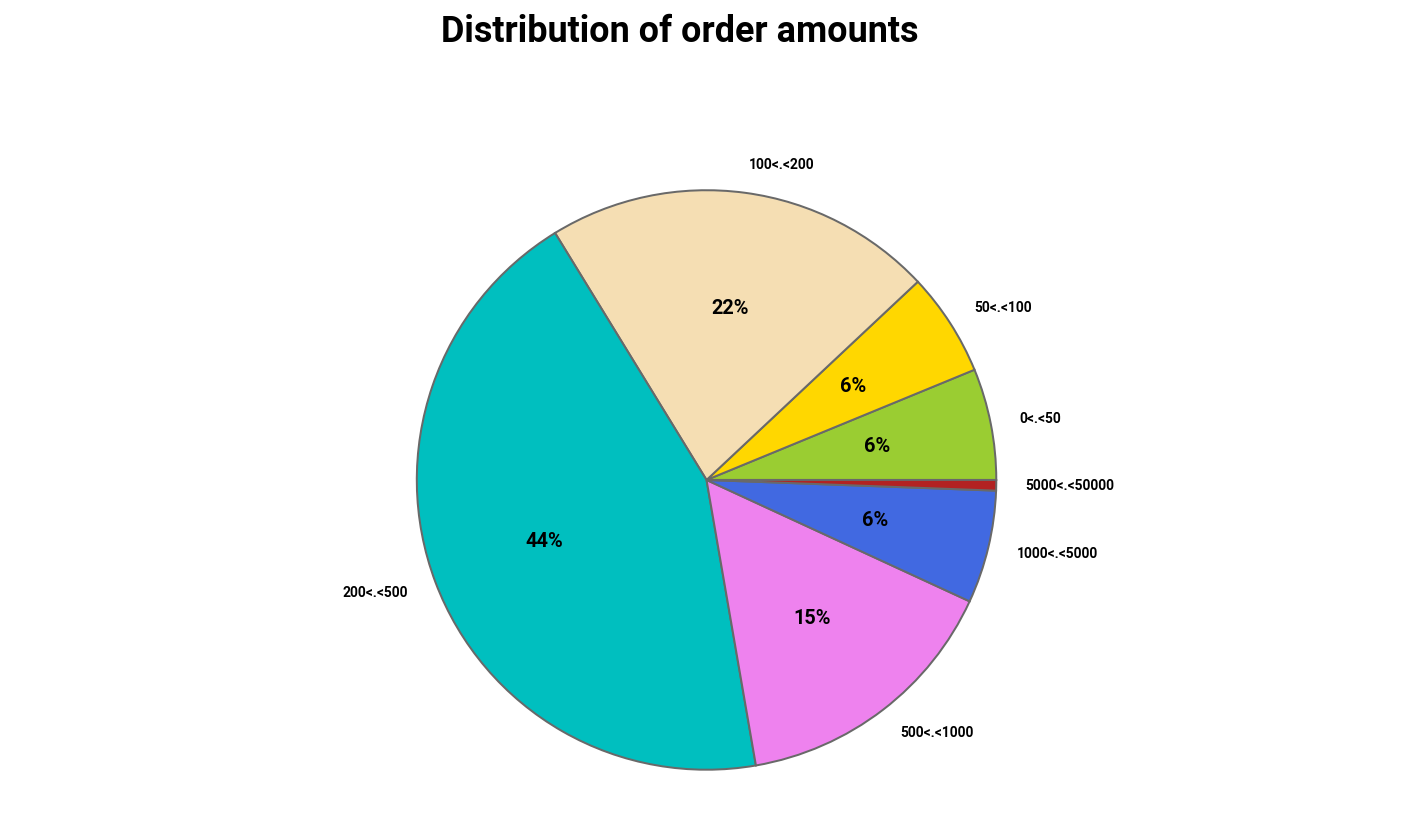

In [21]:
#____________________
# Décompte des achats
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Représentation du nombre d'achats / montant        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

注文の大半は、比較的大きな金額であり、購入の65％は£200を超える金額となっている。


## データ・エンリッチメント

### 製品カテゴリー

製品はStockCodeを通じて一意に識別される。
製品の（断片的な）説明は、Descriptionとして記録されている（StockCodeにたいして一意ではない）。

このセクションでは、製品をさまざまなカテゴリにグループ化するために、Descriptionを使用する。


#### キーワード抽出
最初のステップとして、有用な情報をDescriptionカラムから抽出する。そのための関数を定義。

In [29]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("No. of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

この関数は、データフレームを入力として受け取り、Descriptionに対して、次の操作を実行する。

- 製品の説明に表示される名詞を抽出
- 名詞ごとに、単語の基本形（ルート）を抽出し、この特定の基本形（ルート）に関連する名前のセットを集約
- 各基本形（ルート）がデータフレームに表示される回数をカウント
- 同じ基本形（ルート）に対して複数の単語がリストされている場合、この基本形（ルート）に関連付けられているキーワードが最も短い名前と考える（単数形/複数形のバリエーションがある場合、単数形を選択）

分析の最初のステップとして、製品のリストを取得。

In [30]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

リストを作成したら、それぞれの製品を分析するために、以前に定義した関数を使用する。

In [31]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

No. of keywords in variable 'Description': 1484


この関数を実行すると、3つの変数が返される。

- keywords：抽出されたキーワードのリスト
- keywords_roots：キーがキーワードのルートであり、値がそれらのルートに関連付けられた単語のリストである辞書
- count_keywords：すべての単語が使用された回数をリストする辞書

count_keywords辞書をリストに変換し、出現順にキーワードをソートする。

In [32]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

さらに、最も一般的なキーワードの表現を作成する。

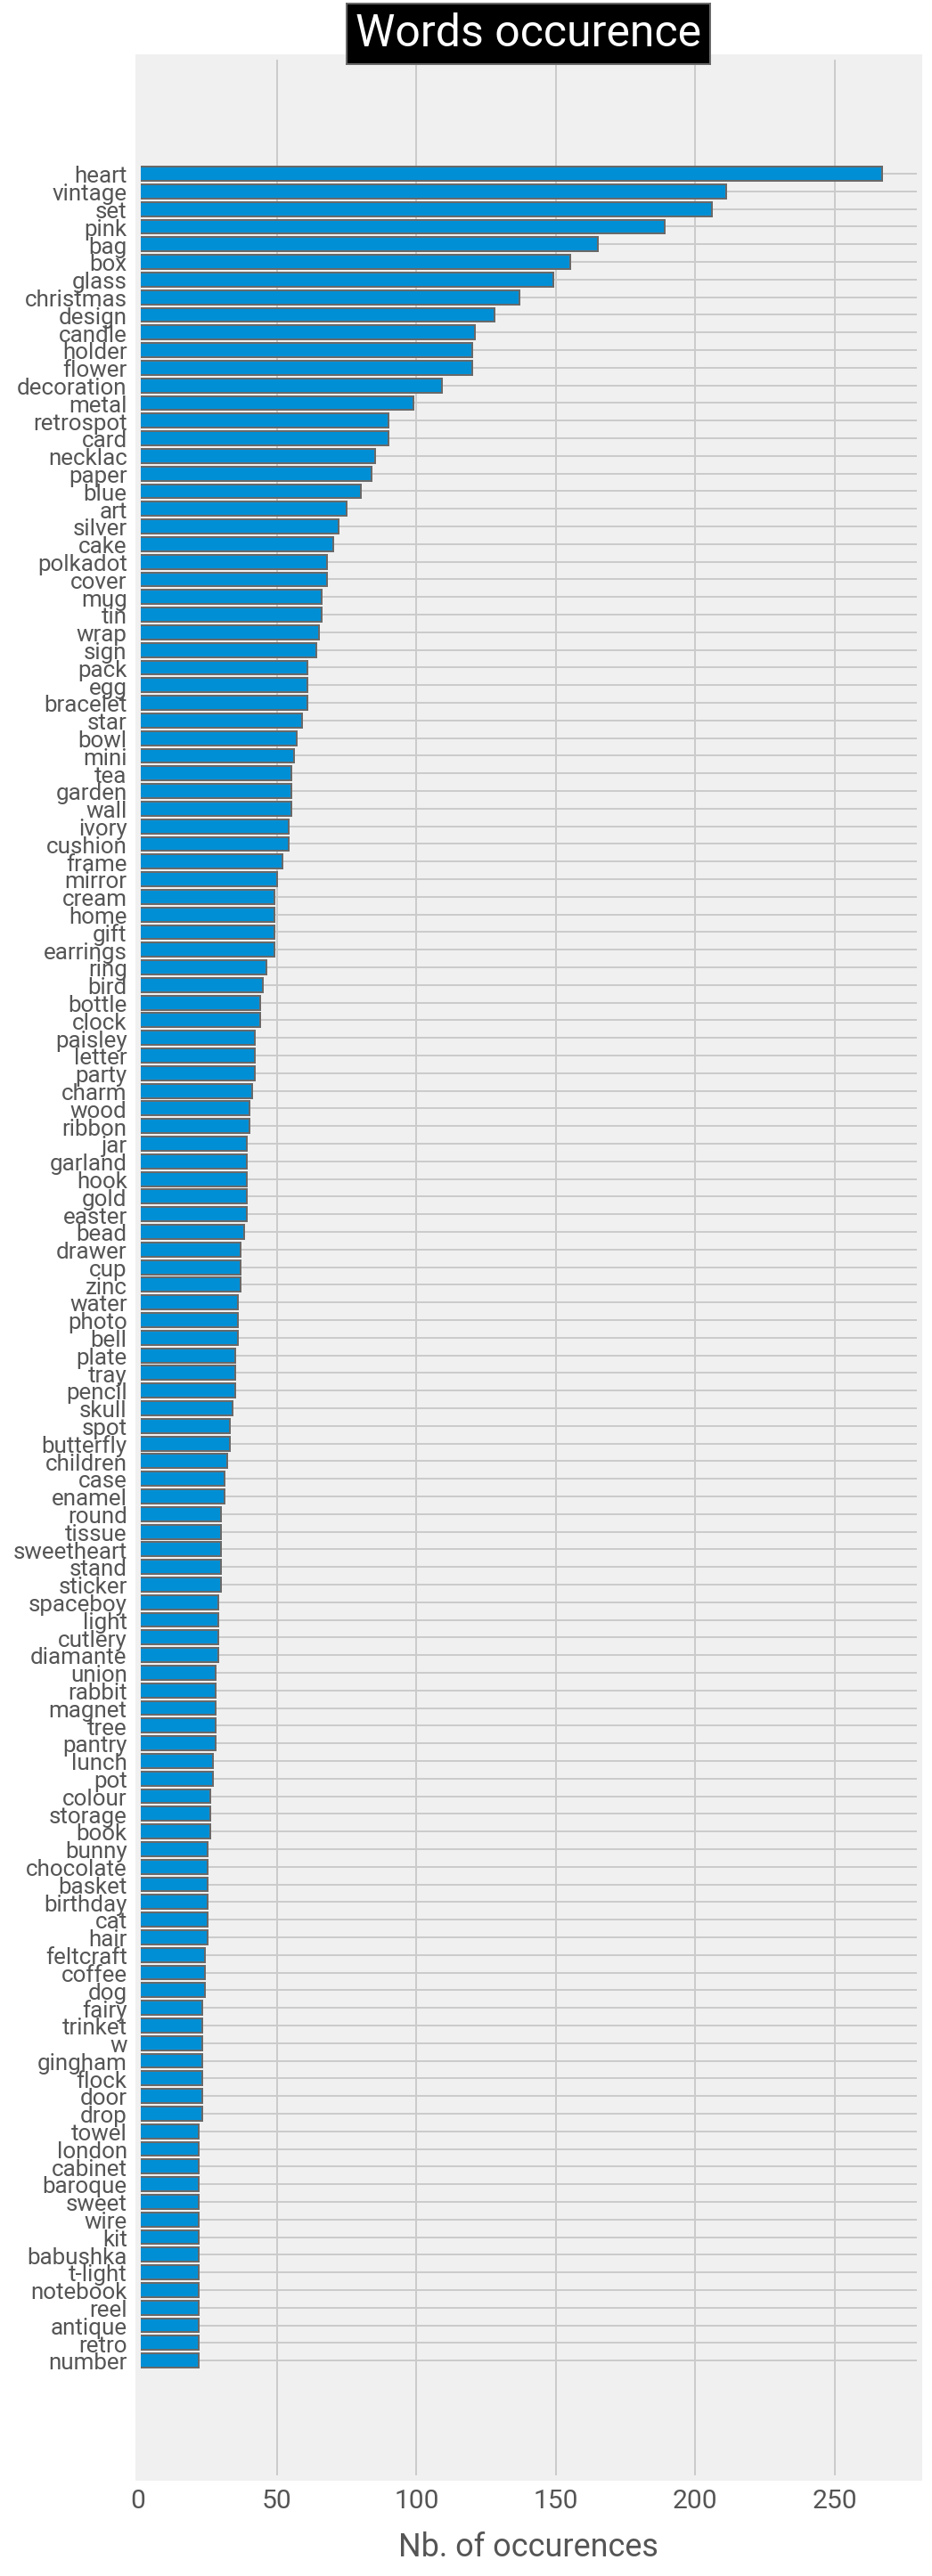

In [33]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

#### 製品カテゴリの作成

取得したリストには1400を超えるキーワードが含まれており、最も頻繁に使用されるキーワードは200を超える製品に含まれている。ただし、リストの内容を調べている間、一部のキーワードは分析の役に立たないことに注意してください（例えば、色などの意味のある情報をもたない）。そのため、これらの単語を破棄し、13回以上出現する単語のみを考慮することにする。

In [34]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Words kept:', len(list_products))

Words kept: 193


#### データのエンコード

次に、これらのキーワードを使用して製品のグループを作成する。初めに、以下の マトリックスXを定義する：

   
|   | word 1  |  ...  | word j  | ...  | word N  |
|:-:|---|---|---|---|---|
| produit 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|produit i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| produit M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

単語nが製品Mに含まれている場合、a_M_nの係数は1、含まれていない場合は0。

In [35]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

マトリックスXは、*ワンホットエンコーディング*を使用して、製品の説明に含まれる単語を表現している。

加えて、価格帯のカテゴリを導入する。6つの列を追加し、製品の価格帯を表現する。

**この処理には一定の時間（２～３分間）を要します。**

In [36]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

価格帯毎の製品の数を確認。

In [37]:
print("{:<8} {:<20} \n".format('Range', 'No. products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Range    No. products         
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


#### 製品クラスタリング

このセクションでは、製品を異なるクラスにグループ化する。バイナリエンコーディング行列の場合、距離の計算に最も適したメトリックは、[Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming)である。ただし、ハミングのメトリックを使用するには、現在のプレートフォームでは利用できないkmodesパッケージを使用する必要があります。したがって、最良の選択ではないが、ここではsklearnのkmeansメソッドを使用する（sklearnのkmeansメソッドは、なユークリッド距離。これは、カテゴリ変数の場合には必ずしも最適な選択ではない）。

データを最もよく表すクラスターのおおよその数を定義するために、シルエットスコアを使用し確認していく。

##### シルエット分析とは？

クラスタ内のサンプルがどの程度密になっているか（凝集度）の目安となるグラフからkを設定する方法。

①クラスタ内部のサンプルの凝集度を計算。

②クラスタ同士の乖離度を計算。

③クラスタの凝集度と乖離度の差を、それらの内大きい法で割り、シルエット係数を得る。

シルエット図は各バーの縦幅がクラスタ内のサンプル数、横軸自体がシルエット係数を表す。
シルエット係数が平均以上であるサンプルが多く、また各バーの縦幅が等しければ、同数の分割ができていることを表す。

つまり、kを変化させながら、シルエット図の各バーの縦幅が同じくらいになっているかどうかを確認し、同じくらいになっていれば均等に分割ができていることが分かる。

In [38]:
matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.1268004588393788
For n_clusters = 5 The average silhouette_score is : 0.14551915467116125
For n_clusters = 6 The average silhouette_score is : 0.15178583093350095
For n_clusters = 7 The average silhouette_score is : 0.15817627133033266
For n_clusters = 8 The average silhouette_score is : 0.14694478266962355
For n_clusters = 9 The average silhouette_score is : 0.1422514043911075


スコア上は、3以上のクラスター数について、すべて 0.1 ± 0.05 程度のスコア差でありこれらはほぼ同等であると見なすことができる。

一方、5つのクラスターを超えると、一部のクラスターに含まれる要素が非常に少ないことがわかった。したがって、データセットを5つのクラスターに分けることにする。

適切な分類を確保するために、可能な限り最高のシルエットスコアを取得するまで繰り返する。結果、約0.15となっている。

In [39]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14740815062347604


#### クラスター内容の特徴づけ（Characterizing the content of clusters）
すべてのクラスの要素の数を確認。

In [40]:
pd.Series(clusters).value_counts()

0    1009
3     964
4     673
1     626
2     606
dtype: int64

##### a. シルエット・スコア (Silhouette intra-cluster score)

クラス分類の品質に関する洞察を得るために、クラスターの各要素のシルエットスコアを図示する。

参考情報：[sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

In [41]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

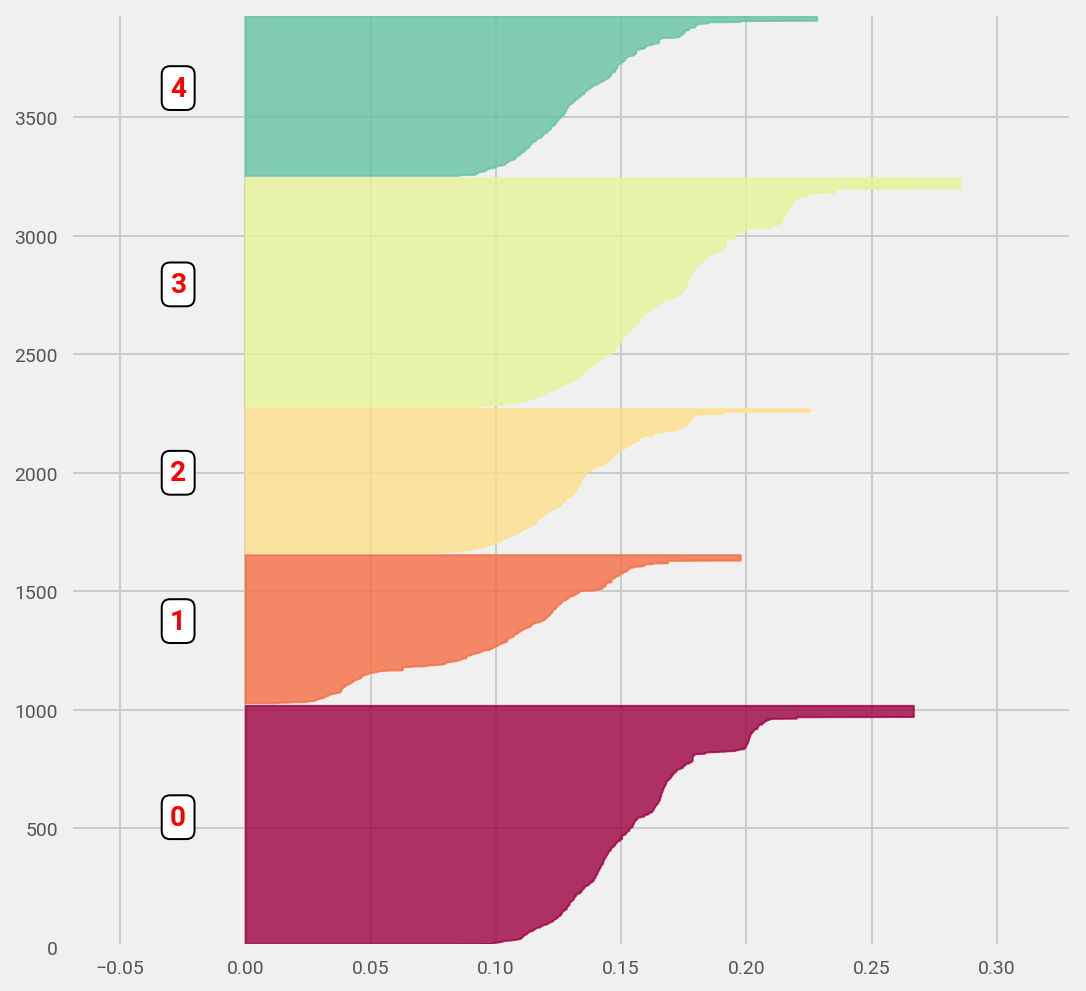

In [42]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

##### b. ワード・クラウド (Word Cloud)

コンテンツの概観を理解するため、各キーワードで最も頻繁に使用されるキーワードを特定する。

In [43]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

結果をワード・クラウド(wordclouds)として表示。

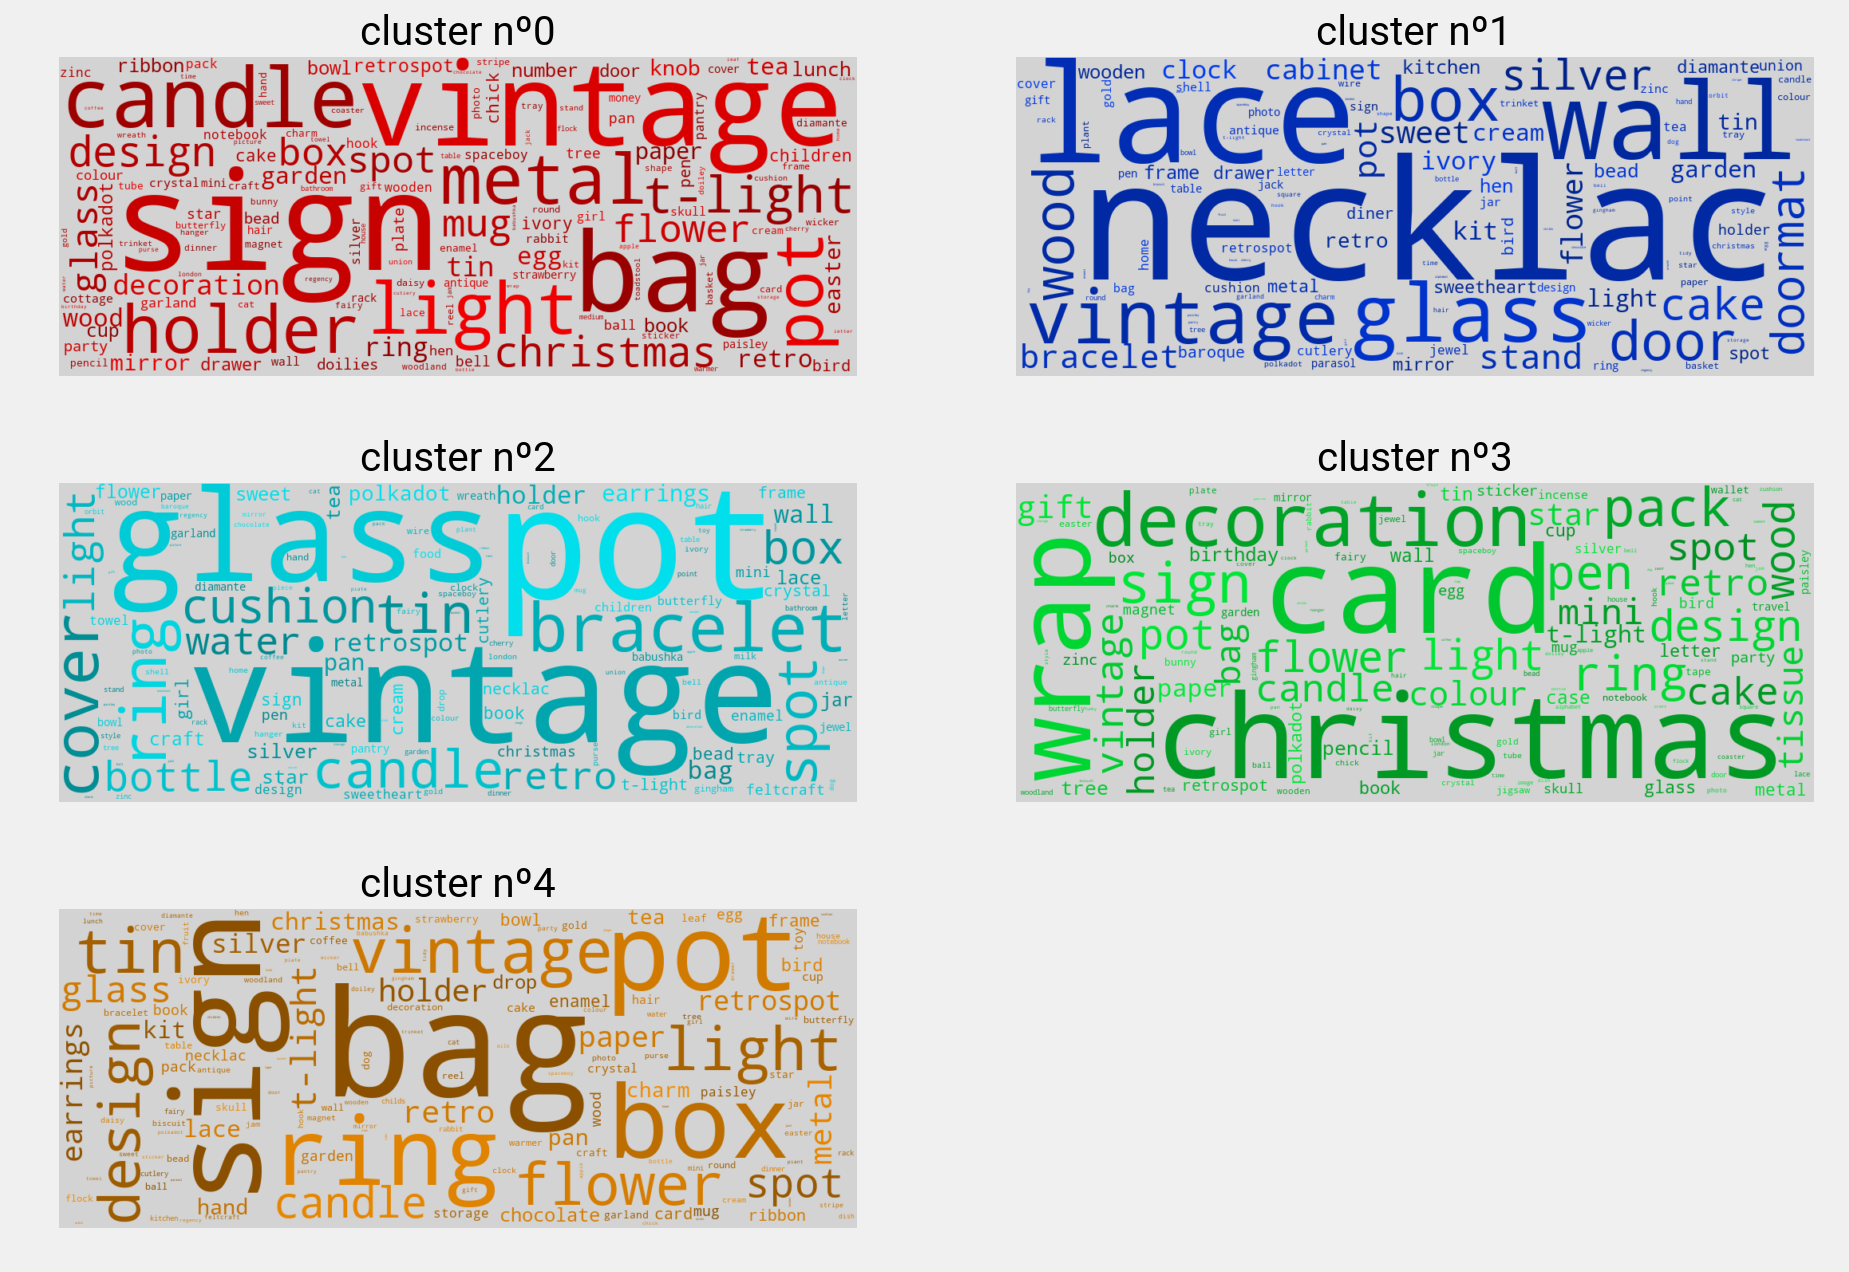

In [44]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

この表現から、たとえば、クラスターの1つは、ギフト（キーワード：クリスマス、パッケージ、カードなど）に関連付けることができる単語が含まれていることがわかる。また別のクラスターには、豪華なアイテムやジュエリー（キーワード：ネックレス、ブレスレット、レース、シルバー、...）が含まれている。一方、多くの共通の単語がさまざまなクラスタに出現していることも観察できる（そのため、これらのクラスターを含まれる単語から明確に区別することは困難といえる）。

##### c. 主成分分析（PCA）

これらのクラスターが実際に明確な分類であることを保証するために、それらの構成を別の方法で確認する。

初期行列の変数の数が多い場合、最初に主成分分析（PCA）を実行する。

##### PCAとは？
たくさんの説明変数を、より少ない指標や合成変数（複数の変数が合体したもの）に要約する手法。 この要約は「次元の縮約」とも表現される。 要約した合成変数のことを「主成分」と呼ぶ。

In [45]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

次に、各コンポーネントによって説明される分散の量を確認。

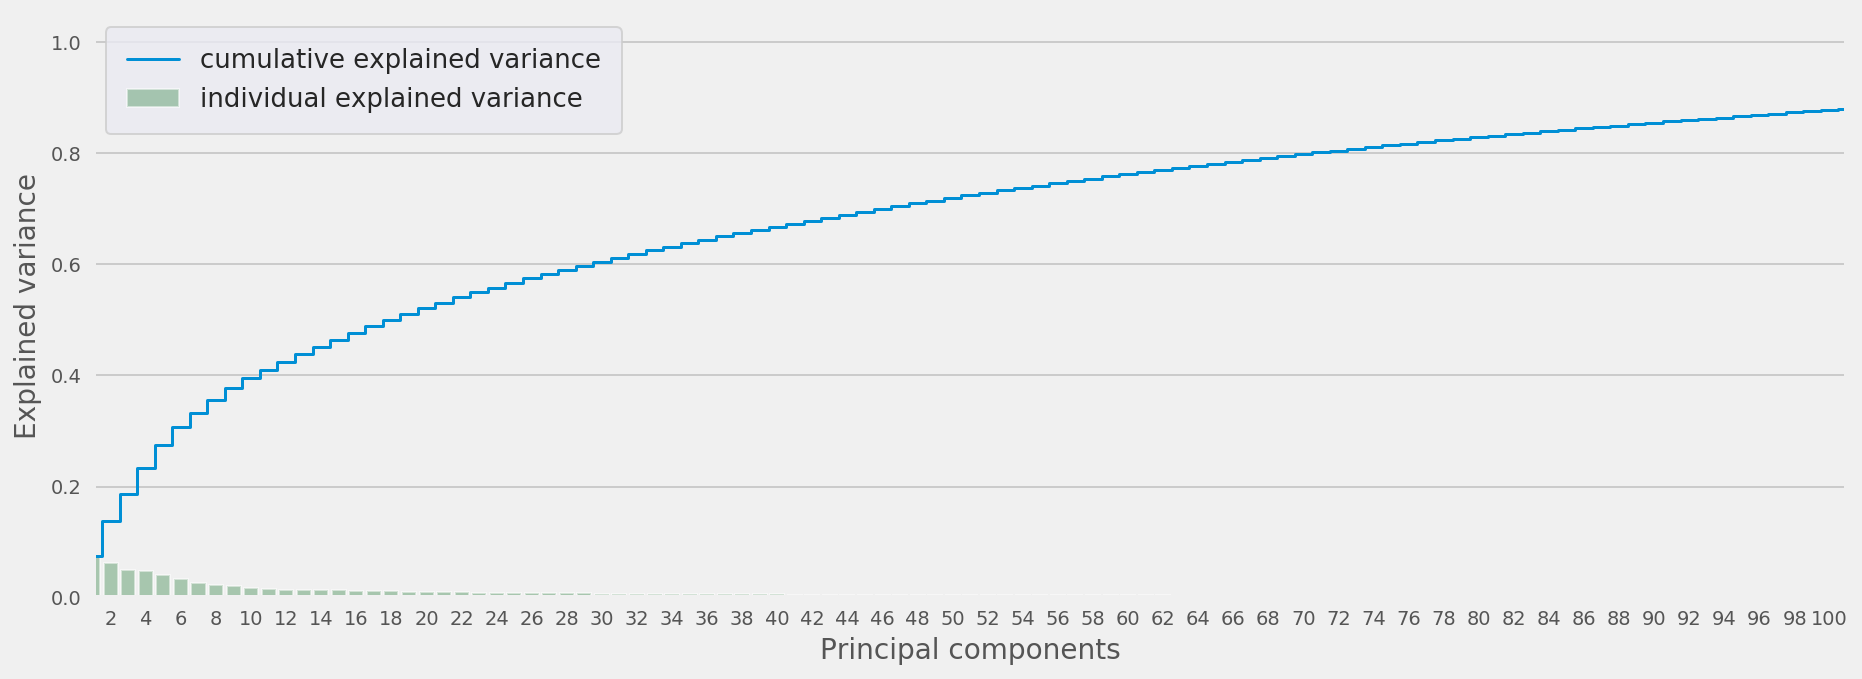

In [46]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

**データを説明するために必要なコンポーネントの数：**データの分散の90％を説明するには100を超えるコンポーネントが利用されていることが見て取れる。実践的に、より絞り込んだコンポーネントを保持する。

In [47]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

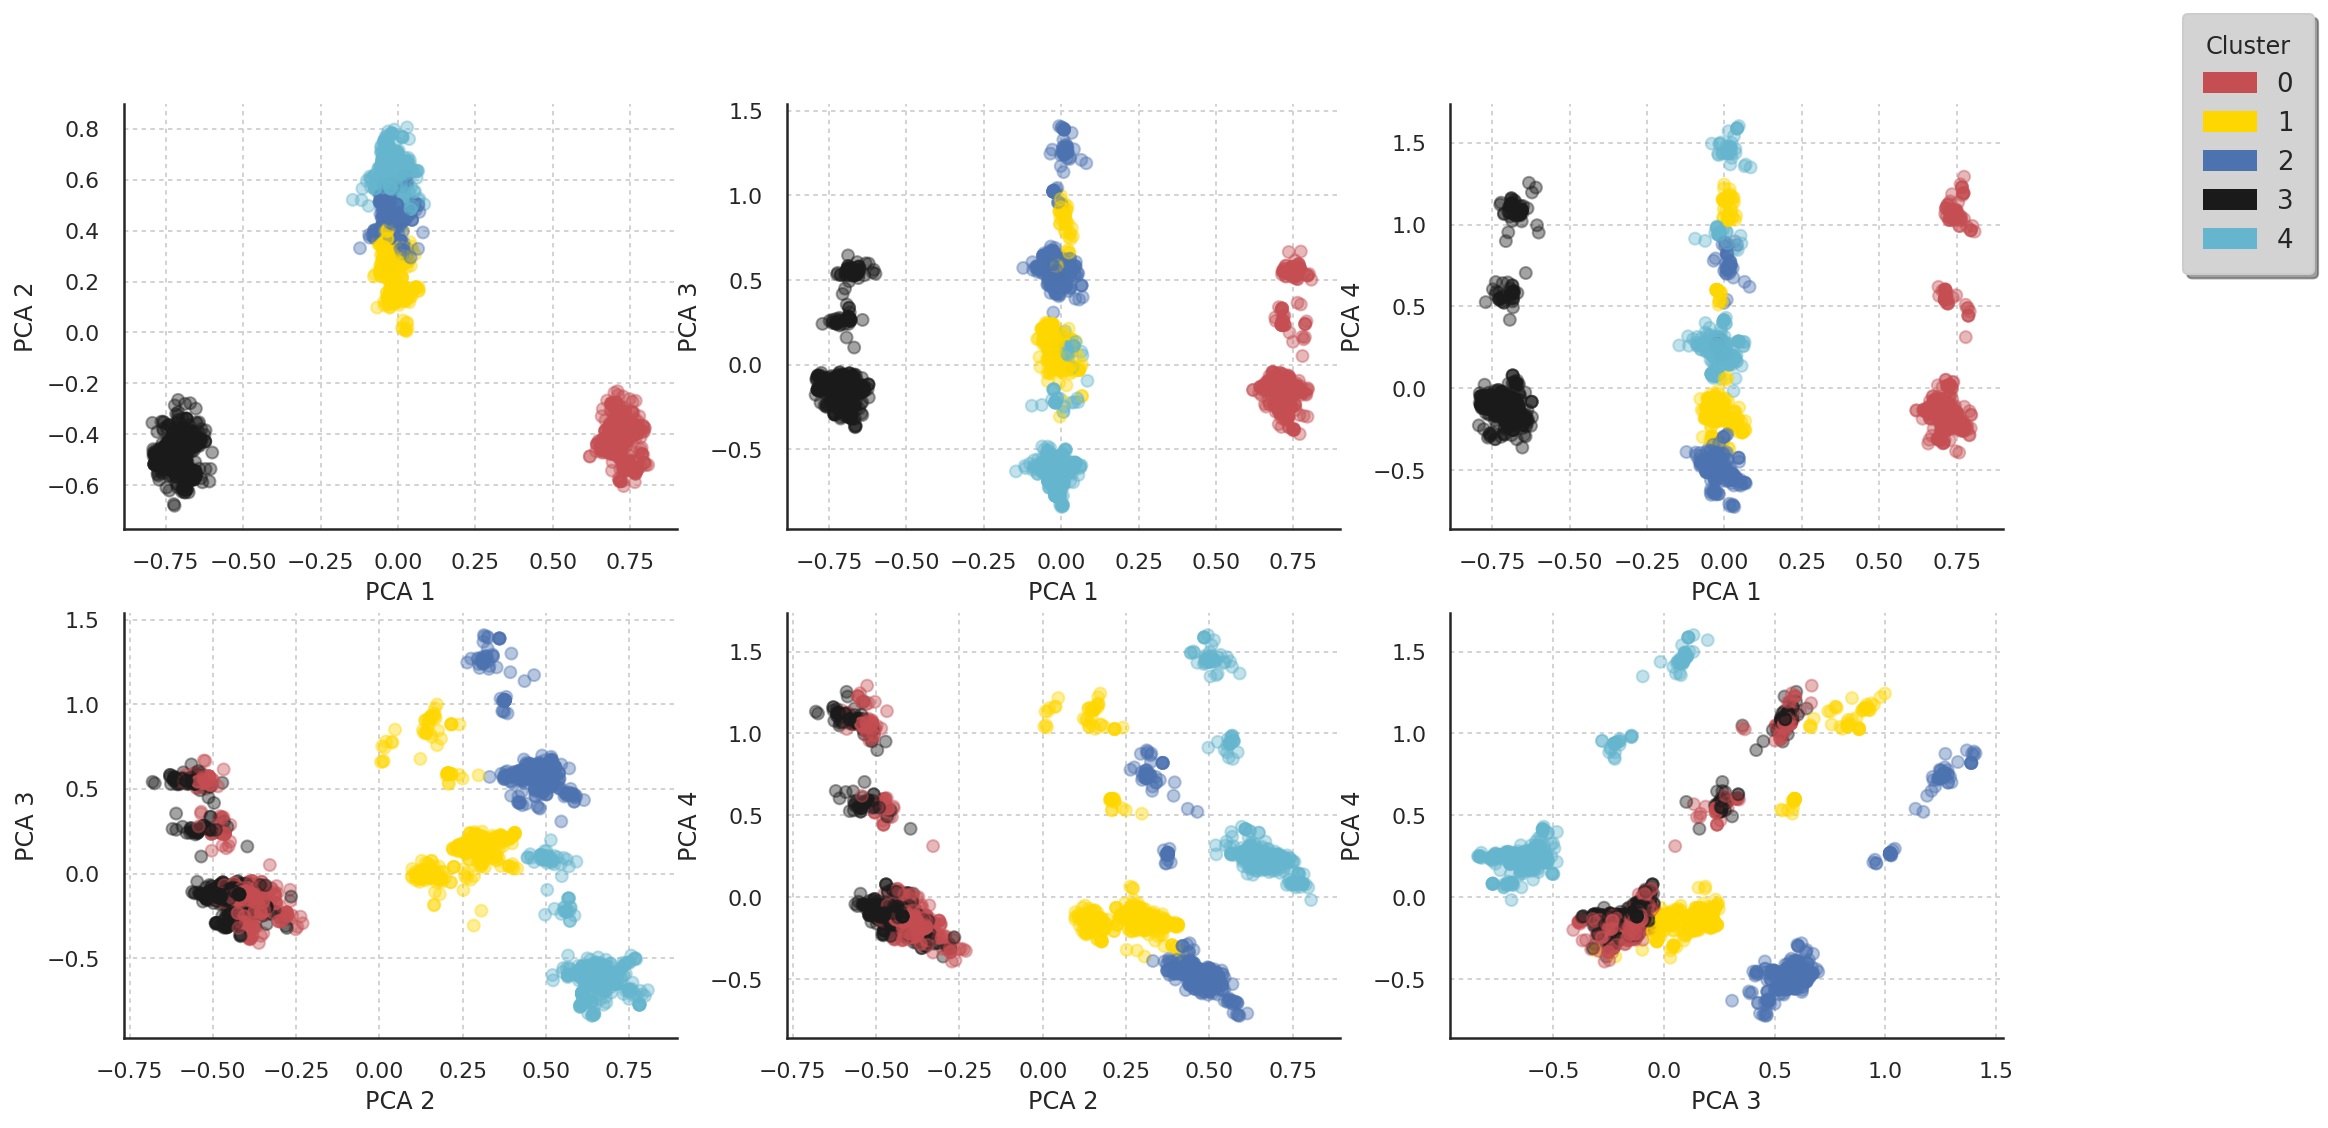

In [48]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

## 特徴量エンジニアリング

### データ・フォーマット

前のセクションでは、さまざまな製品が5つのクラスターにグループ化された。

今後の分析の準備として、この情報をデータフレームに追加する。
各製品のクラスターを示すカテゴリ変数`categ_product`を作成。

In [49]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

#### 製品のグループ化
次のステップとして、categ_N変数を作成（ N∈ [ 0 ：4 ] ）

これは、各製品カテゴリで使われた金額を含む：

In [50]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

InvoiceNo                          Description  categ_product  categ_0  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              4      0.0   
1    536365                  WHITE METAL LANTERN              2      0.0   
2    536365       CREAM CUPID HEARTS COAT HANGER              2      0.0   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              2      0.0   
4    536365       RED WOOLLY HOTTIE WHITE HEART.              2      0.0   

   categ_1  categ_2  categ_3  categ_4  
0      0.0     0.00      0.0     15.3  
1      0.0    20.34      0.0      0.0  
2      0.0    22.00      0.0      0.0  
3      0.0    20.34      0.0      0.0  
4      0.0    20.34      0.0      0.0

１回の注文に関連する情報は、データの複数行（製品ごとに1行）に分割されている。

特定の注文に関連する情報を収集し、エントリに追加する。そのため、注文合計金額と、合計金額の製品の5つのカテゴリへの配分を含む新しいデータフレームを作成。

In [51]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# pourcentage du prix de la commande / categorie de produit
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1      12347    537626        711.79    187.2   124.44   293.35    23.40   
2      12347    542237        475.39    130.5    38.25   169.20    84.34   
3      12347    549222        636.25    330.9    38.25   115.00    81.00   
4      12347    556201        382.52     74.4    19.90   168.76    41.40   
5      12347    562032        584.91    109.7   136.05   158.16    61.30   

   categ_4                   InvoiceDate  
1    83.40 2010-12-07 14:57:00.000001024  
2    53.10 2011-01-26 14:29:59.999999744  
3    71.10 2011-04-07 10:42:59.999999232  
4    78.06 2011-06-09 13:01:00.000000256  
5   119.70 2011-08-02 08:48:00.000000000

#### トレーニング・データとテスト・データへの分割

データフレームbasket_priceには、12か月間の情報が含まれている。

ここでの分析の目的の1つは、サイトを訪問する顧客の習慣を特徴づけ、予測できるモデルを開発すること。

モデルを現実的な方法でテストするため、モデルのトレーニングのための最初の10か月分のデータとテストのための後半2か月分のデータに、データセットを分割。

In [52]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [53]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

#### 顧客毎の注文内容

次のステップでは、同じ顧客のさまざまなエントリをグループ化する。

ユーザーが行った購入数、および購入履歴における最小、最大、平均、合計金額を計算。

In [54]:
#________________________________________________________________
# nb de visites et stats sur le montant du panier / utilisateurs
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      5  382.52  711.79  558.172000  2790.86  29.836681   
1      12348      4  227.44  892.80  449.310000  1797.24  41.953217   
2      12350      1  334.40  334.40  334.400000   334.40  48.444976   
3      12352      6  144.35  840.30  345.663333  2073.98  12.892120   
4      12353      1   89.00   89.00   89.000000    89.00  13.033708   

     categ_1    categ_2    categ_3    categ_4  
0  12.787815  32.408290  10.442659  14.524555  
1  20.030714   0.000000  38.016069   0.000000  
2  11.961722   0.000000  11.692584  27.900718  
3  67.534402  15.711338   0.491808   3.370331  
4  67.078652   0.000000   0.000000  19.887640

最後に、利用頻度に関係する追加の変数を定義〜最初の購入日からの経過日数（FirstPurchase）と最後の購入からの経過日数（LastPurchase)を追加：

In [55]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      5  382.52  711.79  558.172000  2790.86  29.836681   
1      12348      4  227.44  892.80  449.310000  1797.24  41.953217   
2      12350      1  334.40  334.40  334.400000   334.40  48.444976   
3      12352      6  144.35  840.30  345.663333  2073.98  12.892120   
4      12353      1   89.00   89.00   89.000000    89.00  13.033708   

     categ_1    categ_2    categ_3    categ_4  LastPurchase  FirstPurchase  
0  12.787815  32.408290  10.442659  14.524555            59            297  
1  20.030714   0.000000  38.016069   0.000000             5            288  
2  11.961722   0.000000  11.692584  27.900718           240            240  
3  67.534402  15.711338   0.491808   3.370331             2            226  
4  67.078652   0.000000   0.000000  19.887640           134            134

分析の目的から特に関心のある顧客カテゴリは、1回だけしか購入していない顧客のカテゴリです。

このタイプの顧客は、顧客全体の1/3を占めていることがわかる。

たとえば、これらの顧客をターゲットにして、顧客を維持するための施策を行うことが考えられる。

In [56]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. of customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. of customers with single purchase: 1445/3608  (40.05%)


### 顧客カテゴリの作成

#### データのエンコード

データフレーム`transactions_per_user`の各エントリは、顧客毎の情報を保持している。この情報を使用して、顧客のタイプを特徴付ける。（最終的に、変数のサブセットのみを保持する。）

In [57]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

変数は、それぞれ取りうる値の範囲がかなり異なっており、分析を続行する前に、それらの値が標準化されたマトリックスを作成する。

In [58]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  25.22916919
  23.21847344  16.37327913  13.98907929  21.19884856]


以下で、顧客のクラスターを作成する。

まず、顧客のクラスターを作成する前に、より次元数の少ないマトリックス`scaled_matrix`を定義する。このクラスターを使用して、グループに分割する能力を検証する。

そのために、事前に主成分分析(PCA)を実行する。

In [59]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

各コンポーネントによって説明される分散の量を表示する。

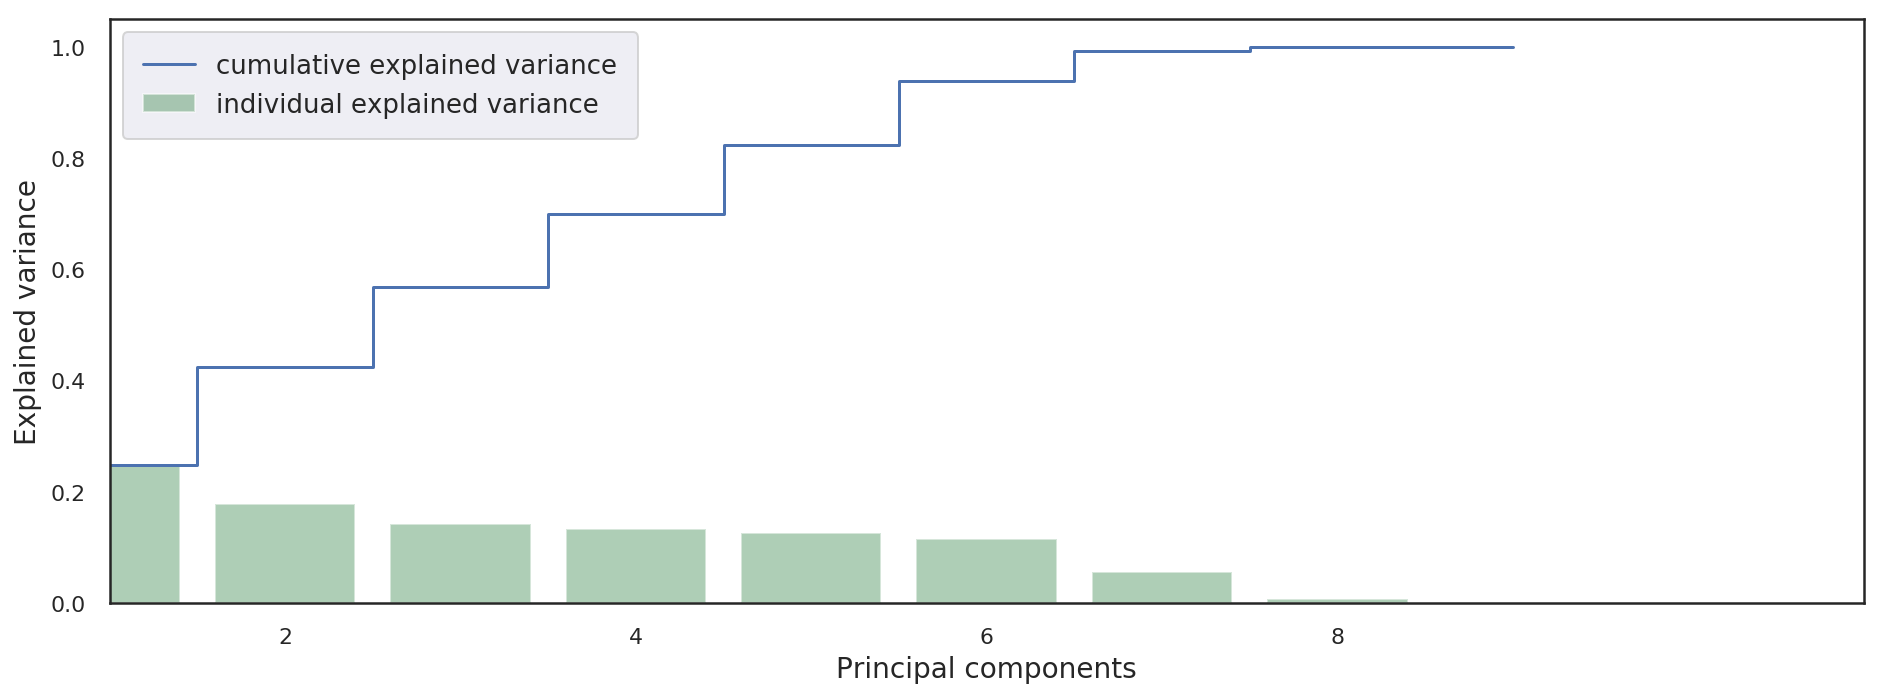

In [60]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

#### 顧客カテゴリの作成
先に`scikit-learn`の`k-means`アルゴリズムを使用して定義された標準化マトリックスから、顧客のクラスターを定義する。シルエットスコアに基づいてクラスターの数を選択すると、11のクラスターで最高のスコアが得られることがわかる。

In [61]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('Silhouette Score: {:<.3f}'.format(silhouette_avg))

Silhouette Score: 0.216


各クラスターの顧客の数を調べる。

In [62]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['No. of Clients']).T

1    8    6    4    7    10   0    5   2   3   9 
No. of Clients  1396  501  454  287  285  243  229  166  28  11   8

#### a. PCA実施後のレポート

作成されたグループのサイズには、一定の格差がある。グループ間分割の有効性を検証するために、これらのクラスターの内容を理解する必要がある。まず、PCAの結果を使用する。

In [63]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

さまざまな組み合わせでクラスターの表現を作成。

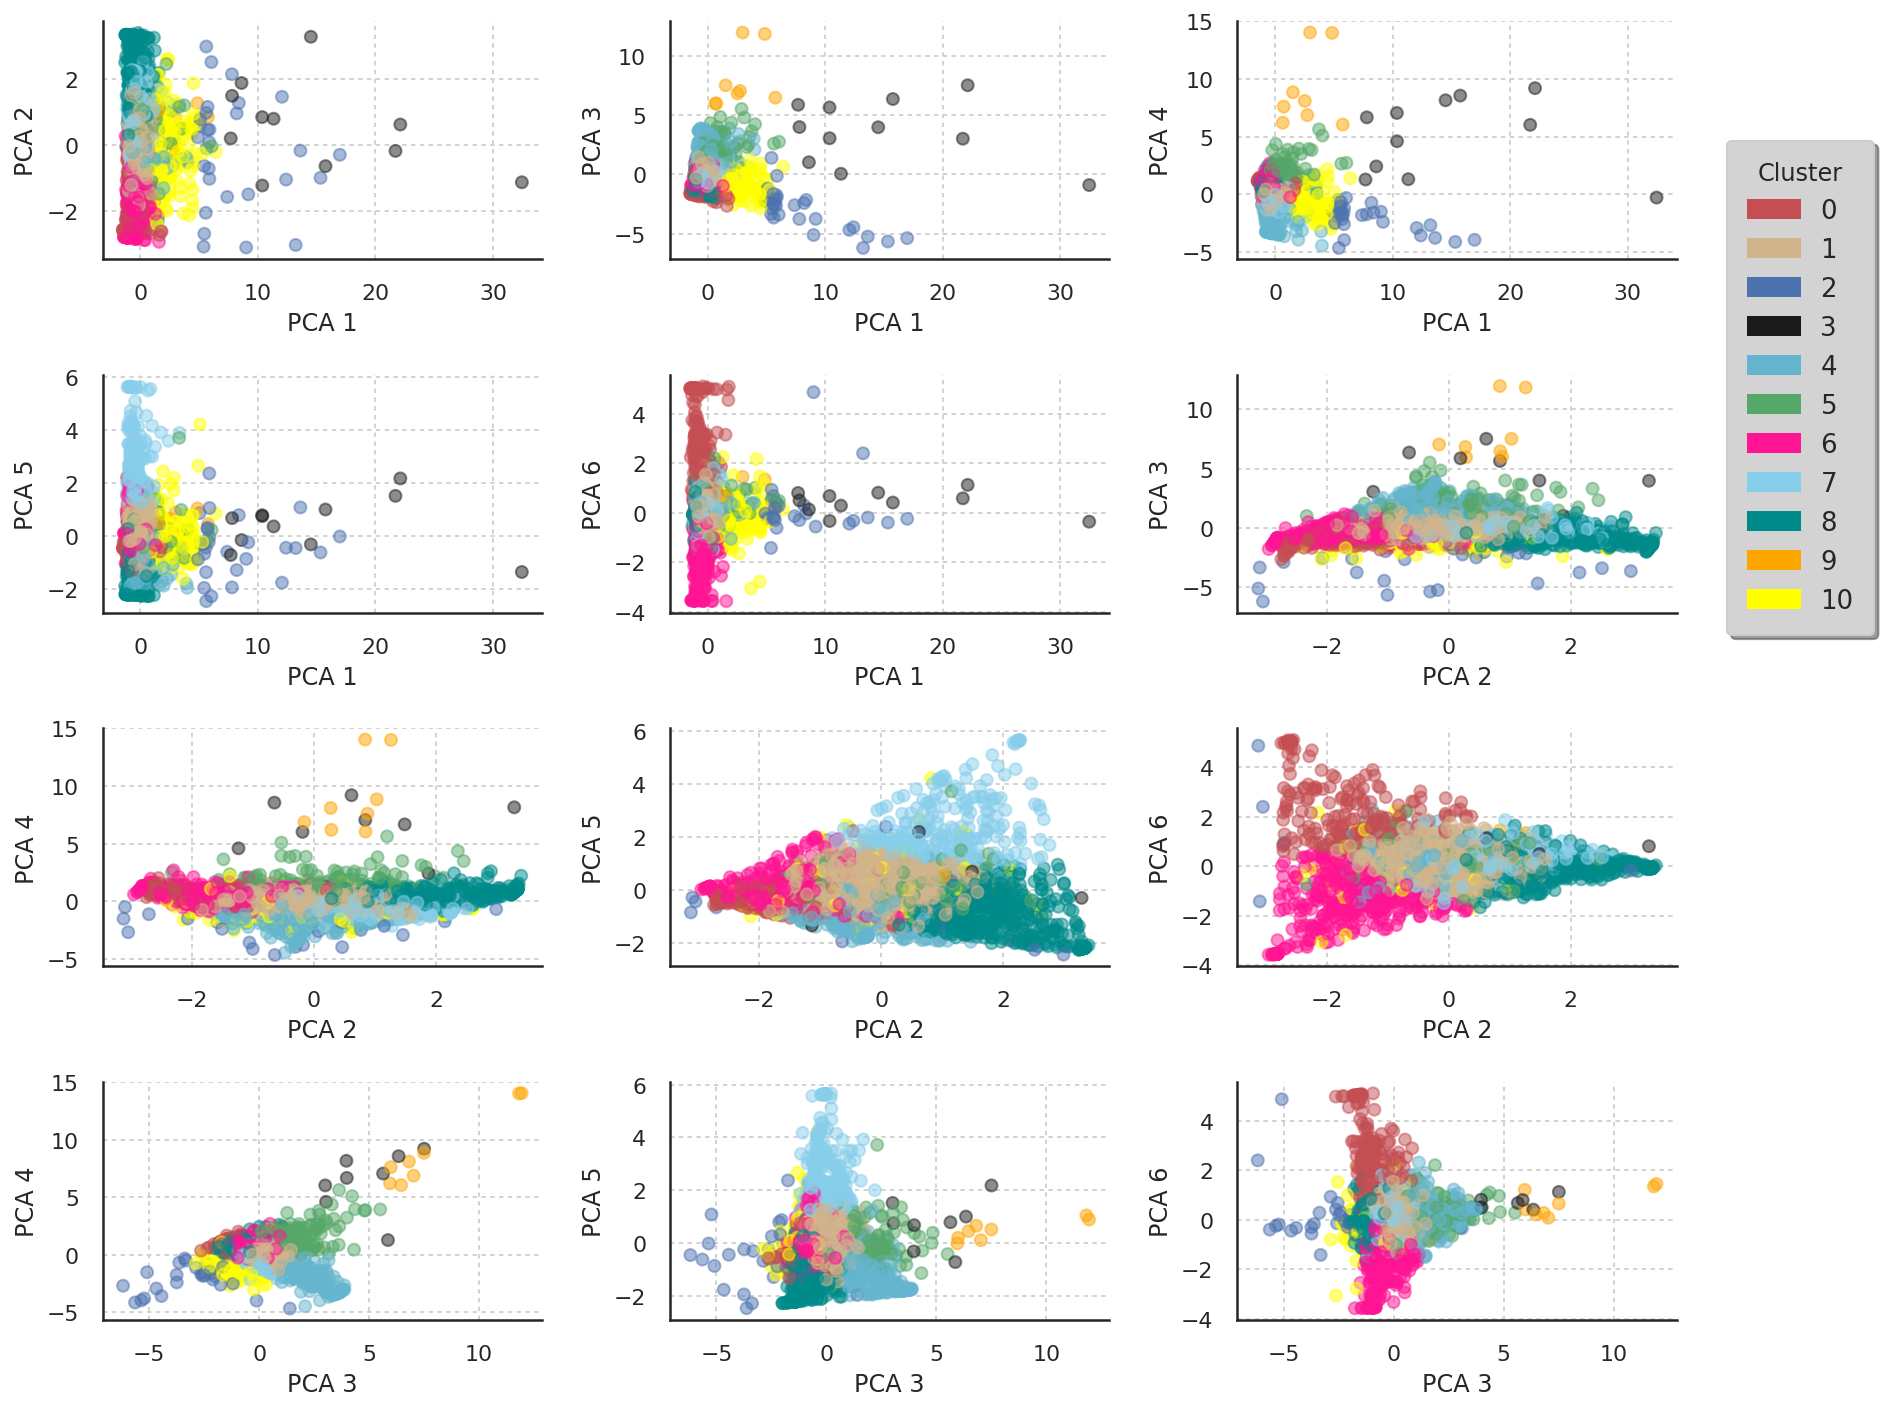

In [64]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

上の図から、たとえば、最初の主成分（PCA1）によって、最も数の少ないクラスターを残りのクラスターから分離できることがわかる。具体的には、2つのクラスターが明確に区別されることがわかる。


#### b. シルエット・スコア

分離の品質を調べるもう1つの方法として、クラスターのシルエットスコアを調べる。

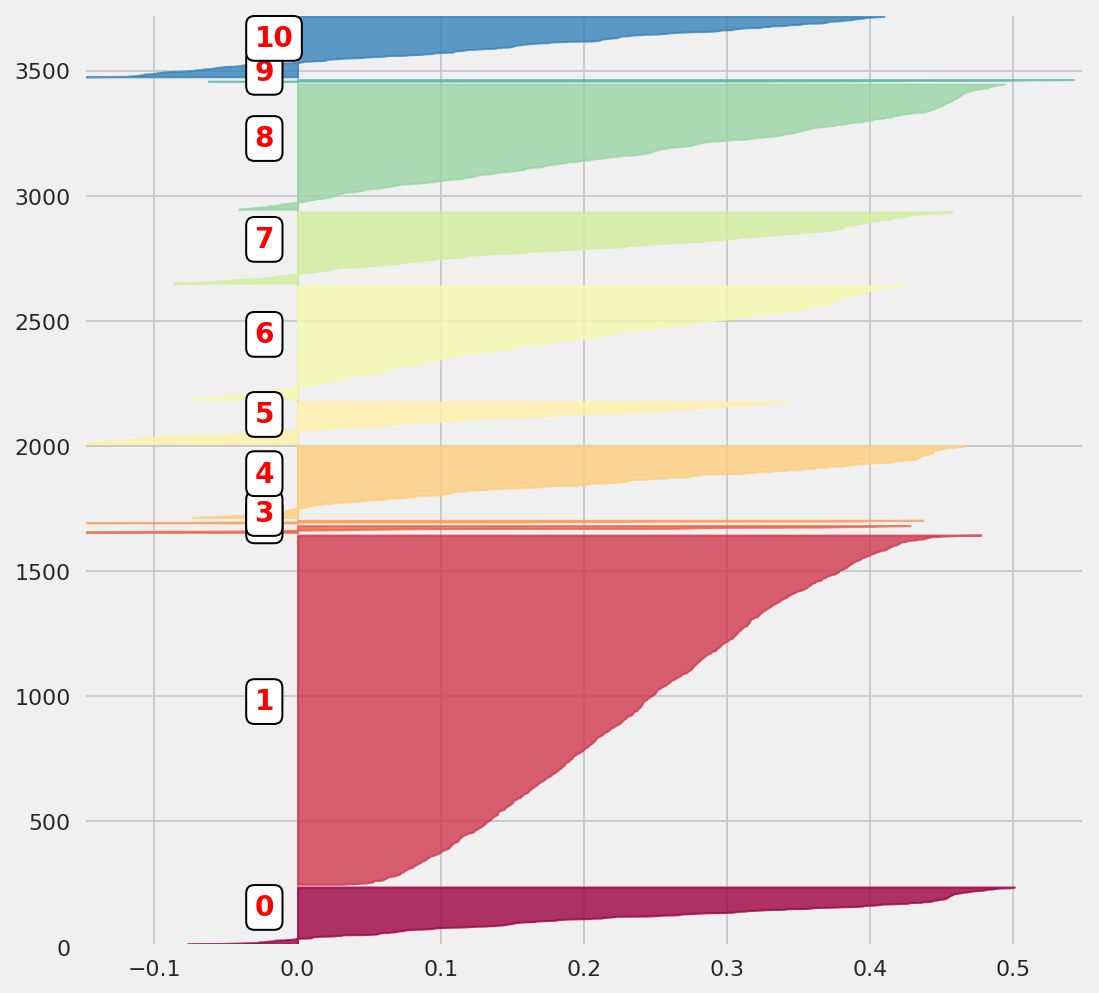

In [65]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

#### c. 顧客の様態（morphotype）

さまざまなクラスターが、大局的に見て、互いに疎であることを確認した。

後は、各クラスターの顧客の習慣を理解する課題が残っている。
そのために`selected_customers`データフレームに、各クライアントが属するクラスターを定義する変数を追加する。

In [66]:
selected_customers.loc[:, 'cluster'] = clusters_clients

次に、まず顧客のグループ毎に、このデータフレームのコンテンツ（たとえば、平均注文合計金額、訪問数、または顧客クラスター毎の購入合計金額）を平均化する。また、各グループの顧客数（`size`変数）も定義する。

In [67]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


最後に、データフレームのコンテンツを再編成する。

In [68]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

cluster      count          min           max         mean           sum  \
0       6.0   2.427313   208.768282    320.416280   261.909961    656.081412   
1       8.0   2.576846   197.313954    338.359860   257.978608    690.225331   
2       7.0   2.094737   197.689825    323.990807   254.030783    621.499895   
3       0.0   2.183406   190.950961    315.276638   243.978633    578.924541   
4       4.0   2.578397   210.475017    374.176237   287.830200    810.700453   
5       1.0   3.209885   207.293676    439.339521   315.400461   1040.975832   
6      10.0   1.913580   835.563004   1257.516259  1021.034943   2119.952720   
7       2.0   1.500000  2603.577857   2889.069643  2734.716429   4159.342500   
8       5.0  17.500000    84.273193   1310.317651   494.874096   8579.587349   
9       9.0  87.125000    20.862500   2643.812500   456.526689  37313.235000   
10      3.0  22.909091   385.752727  16513.428182  4601.666146  83676.573636   

      categ_0    categ_1    categ_2    categ_3    categ_4  size  
0   57.370622   9.452785   7.730822  12.641320  12.807729   454  
1   11.019810  62.548922  10.870033   4.708794  10.863704   501  
2   13.411825  15.154412  51.649616   6.340915  13.497580   285  
3   18.158996   7.305926   6.006072  57.740869  10.788137   229  
4   14.808710  10.045164   6.883201   6.959781  61.303144   287  
5   25.575851  20.737661  17.476380  14.027375  22.186979  1396  
6   26.762554  21.839279  17.120593  12.840702  21.437149   243  
7   20.045484  27.806898  15.852323  17.215839  19.079455    28  
8   24.317579  22.498453  16.500690  12.041918  24.660237   166  
9   25.165035  24.794942  13.979829  11.477885  24.604929     8  
10  20.206767  27.294114  17.813890   6.520520  28.164710    11

最後に、顧客の様態(morphotypes)を表現するため、「レーダーチャート」を作成するクラスを定義する。

参考情報：[kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave-read-this)

In [69]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


このクラスを用いて、各クラスターの内容を大局的に図示する。

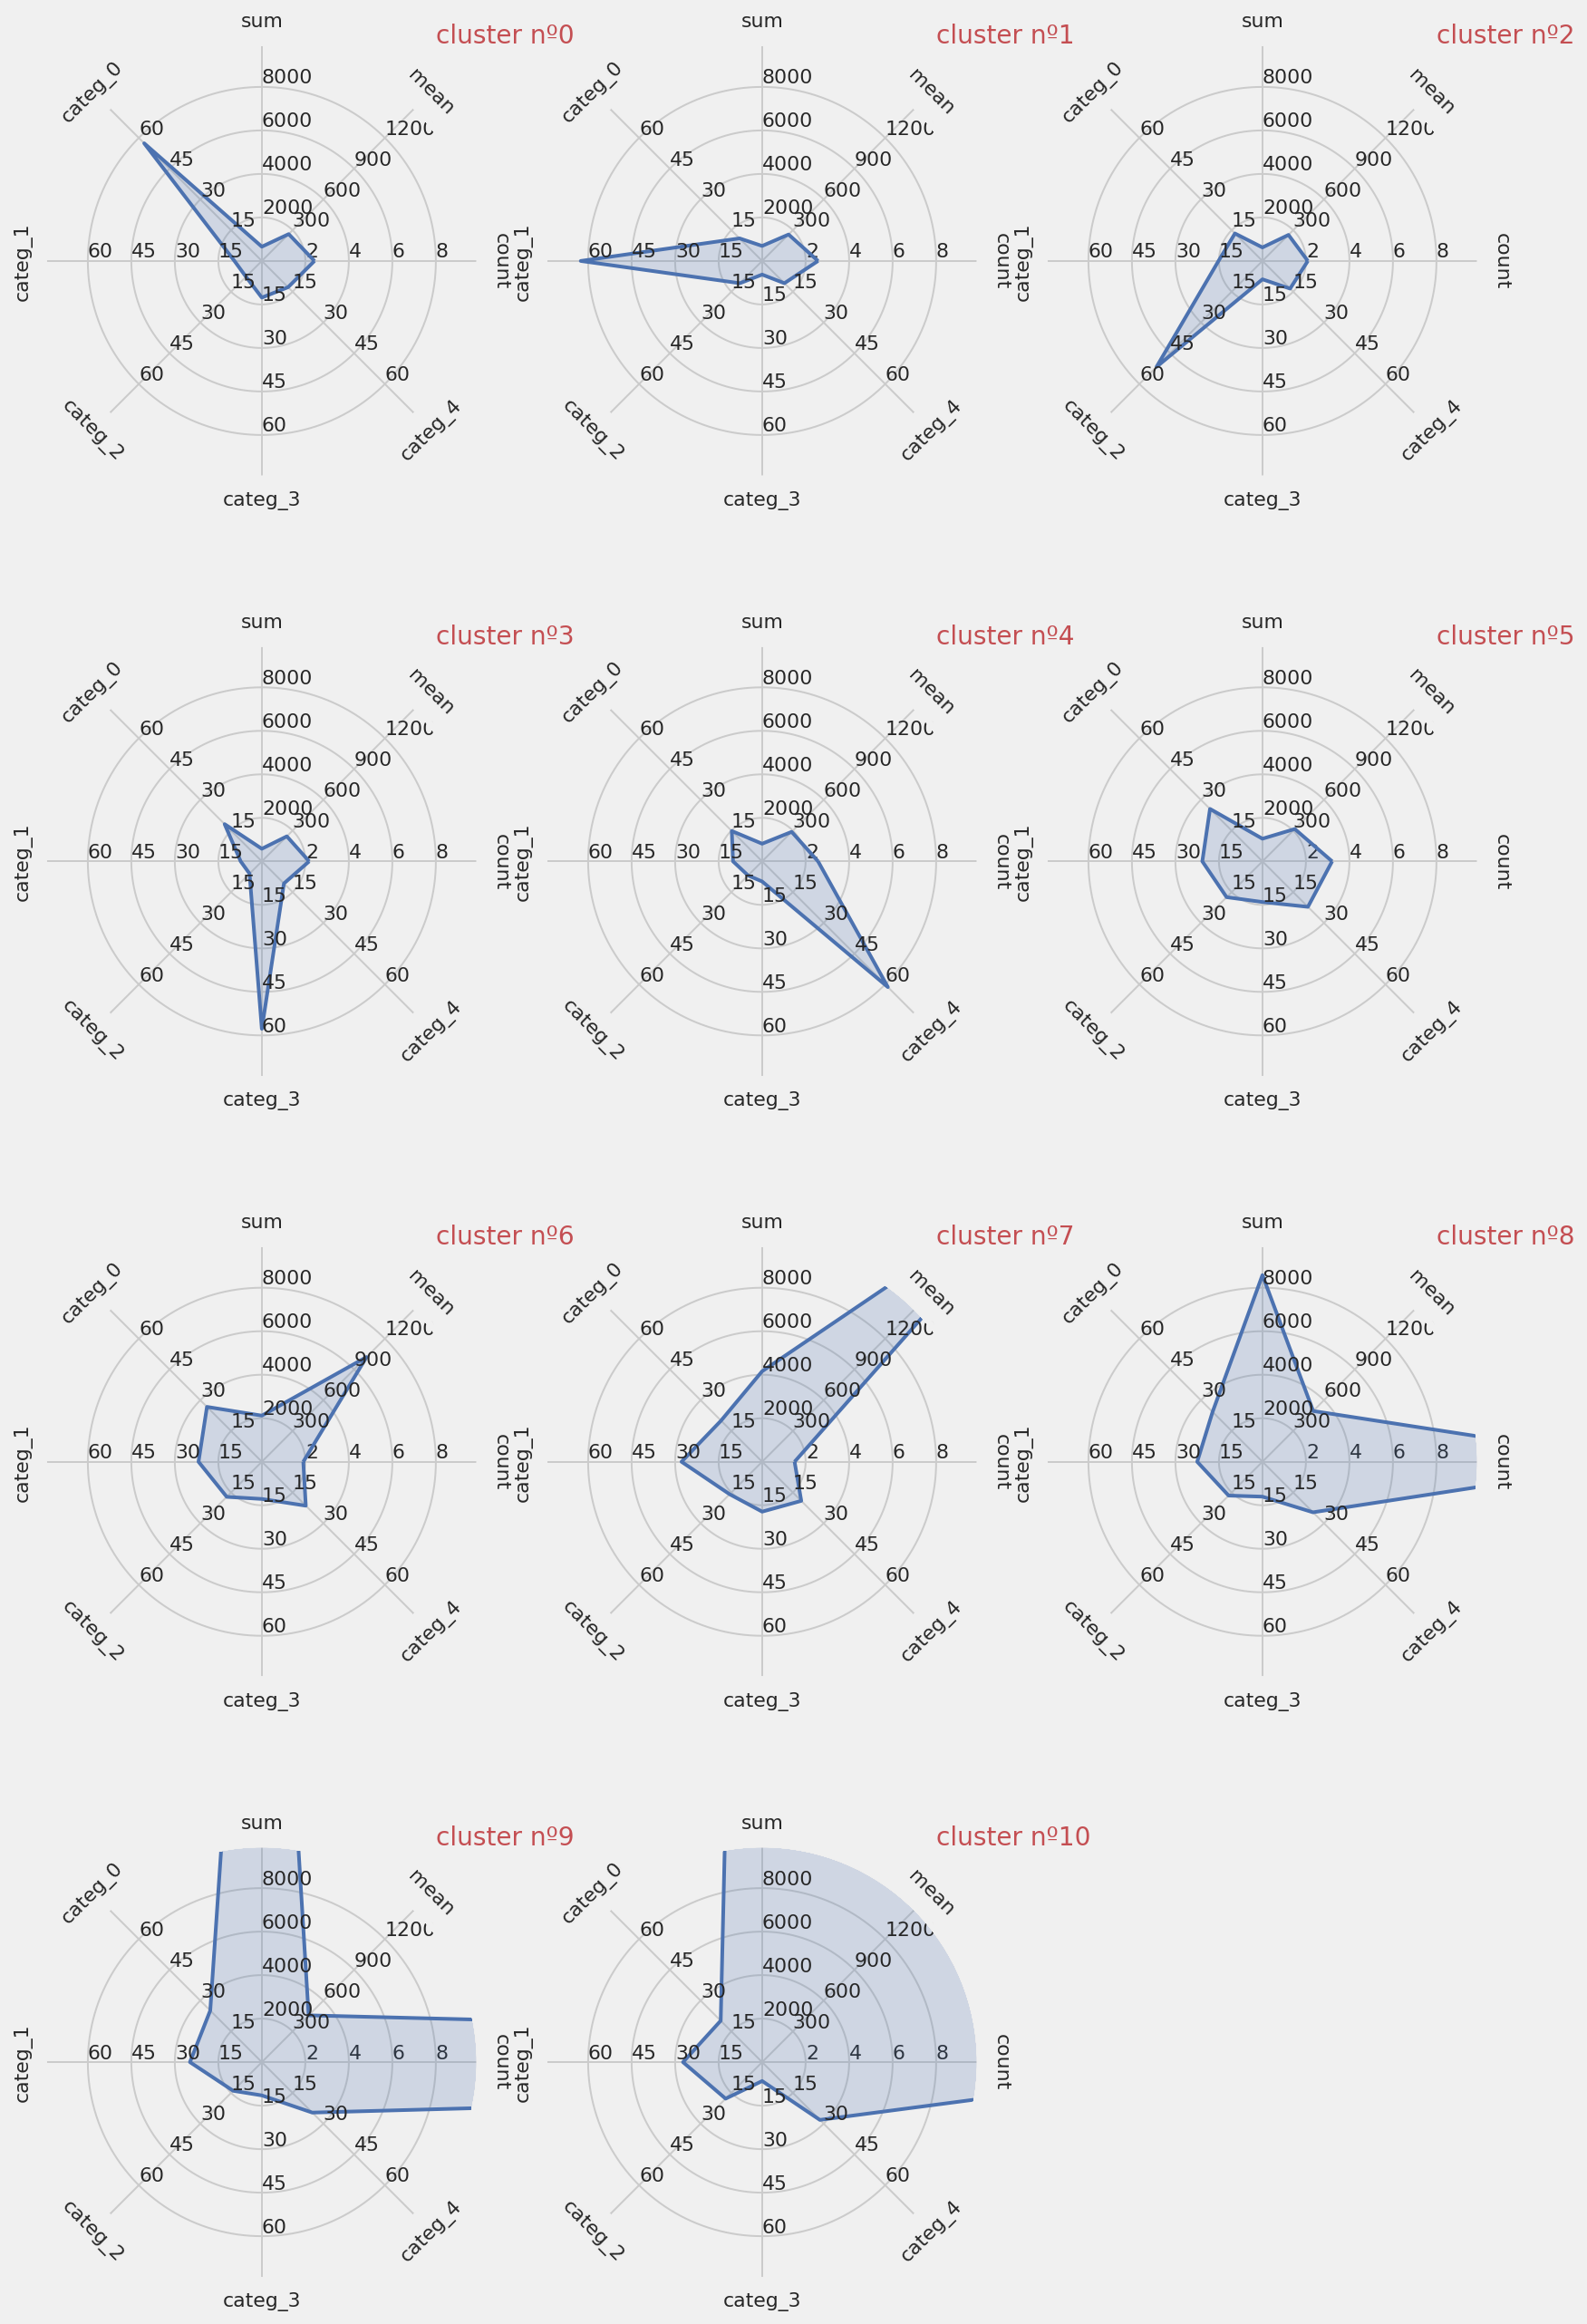

In [70]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

たとえば、最初の5つのクラスターは、製品の特定のカテゴリに強い選好を持っていることがわかる。他のクラスターはそれぞれ、注文合計金額平均（**mean**）、クライアントが費やした購入金額合計（**sum**）、または訪問の合計数（**count**）が他と異なる。


## 顧客クラス分類
このパートでは、前のセクションで確立されたさまざまなクライアントカテゴリで消費者を分類する分類器(Classifier)を構築する。

目的は、顧客の最初の訪問時点で、分類を可能にすることである。scikit-learnで実装されているいくつかの分類器を検証する。

最初に、それらの使用を簡素化するために、分類器に共通する機能をインターフェースとして持つクラス`Class_Fit`を定義する。

In [71]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

最初の購買で、顧客が属するクラスを判別することが目的であるため、注文（バスケット）の内容に関する変数のみを保持し、訪問の頻度や注文内容の経時変化に関連する変数は考慮しない。

In [72]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

最後に、データセットをトレーニング・セットとテスト・セットに分割する。

In [73]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

### サポートベクターマシン分類器（Support Vector Machine Classifier: SVC）
SVC分類器を使用する。

`Class_Fit`クラスのインスタンスを作成してから`grid_search`関数を呼び出す。関数へは、次のパラメーターを渡す。

- 最適な値を導くためのハイパーパラメーター
- 交差検定に使用されるフォールドの数

In [74]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

トレーニング・データで分類器をトレーニングする。

**この処理には一定の時間（１分間程度）を要します。**

In [75]:
svc.grid_fit(X = X_train, Y = Y_train)

テストデータを用いて予測性能をテストする。

In [76]:
svc.grid_predict(X_test, Y_test)

Precision: 85.60 % 


#### 混同行列

結果の精度は正しくみえる。

ここで、クラスが定義されたときに、取得されたクラス間でサイズの不均衡があったことを思い出す必要がある。

特に、ある1つのクラスには約40％の顧客が含まれていた。ここで、予測と実際の値とを比較することは興味深い試みとなる。

これは混同行列の対象である。sklearnドキュメンテーションに掲載されているコードを使用する。

参考情報：[sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

##### 混同行列とは

2 値分類問題で出力されたクラス分類の結果をまとめたマトリックス(行列)。2 値分類機械学習モデルの性能を測る指標として使われる。

In [77]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

上の関数を用いて、混同マトリックスを表示する。

Confusion matrix, without normalization


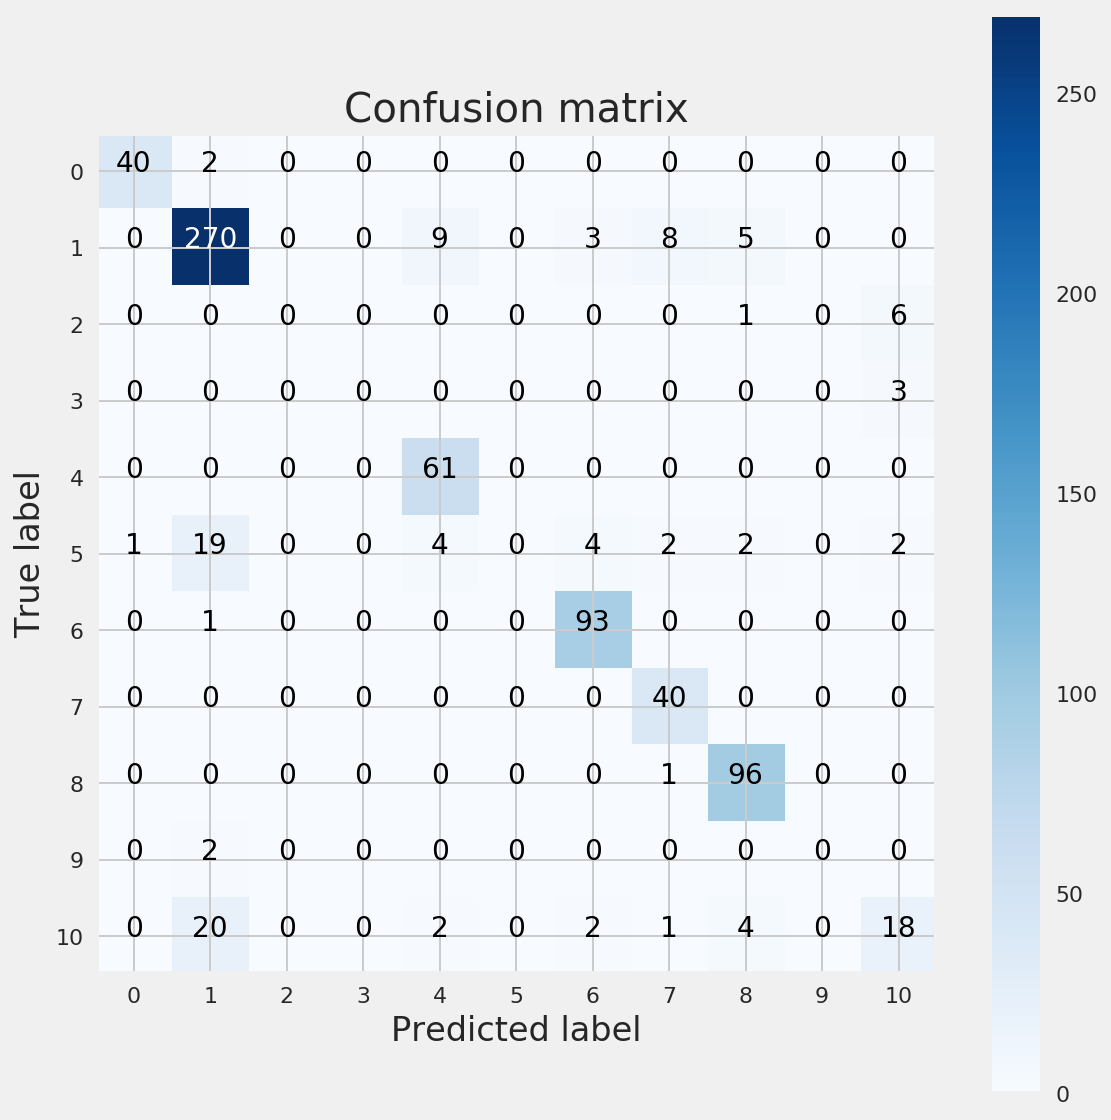

In [78]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

#### 学習曲線
学習過程(フィッティング)の性能をテストする一般的な方法は、学習曲線を描くことである。
この学習曲線を使用して、モデルの潜在的な欠点、たとえばオーバーフィッティングまたはアンダーフィッティングを検出することができる。

scikit-learnドキュメンテーションのコードを使用する。

参考：[scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-self-examples-model-selection-pad-learning-curve-py)

In [79]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

上の関数を用いて、SVC分類器の学習曲線を表示。

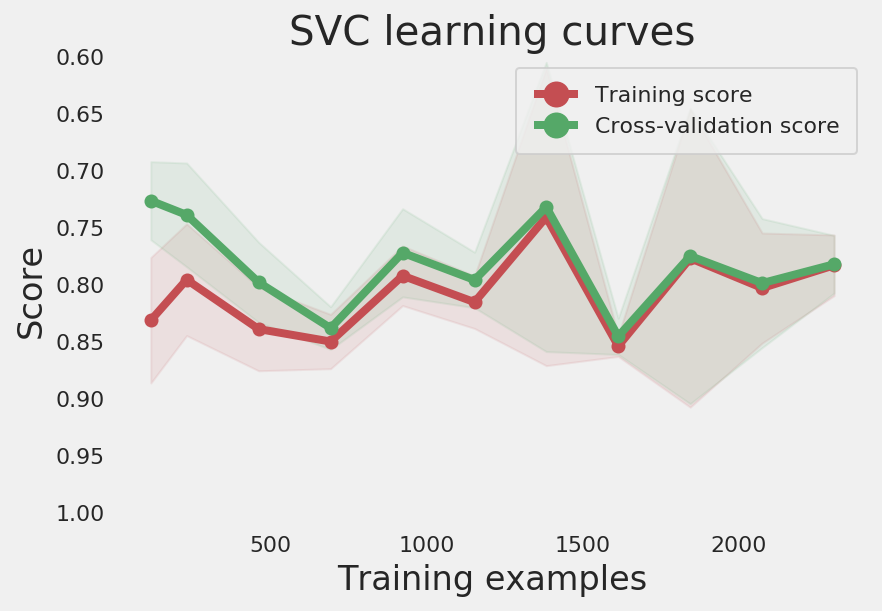

In [80]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

サンプルサイズが大きくなるに連れ、トレーニング・スコアおよび交差検定曲線が同じ限界に向かって収束することがわかる。これは、分散が少ないモデリングの典型であり、モデルが過剰適合の影響を受けないことを証明している。また、トレーニングカーブの精度が正しいことがわかる。これは、低バイアスの同義語である。モデルはデータにアンダーフィットしていない。



トレーニングデータでのモデルのパフォーマンスが悪いときは、モデルがトレーニングデータにアンダーフィットしていることになる。これは、モデルが入力 (X ) とターゲット (Y ) の関係をキャプチャできないことが原因である。
トレーニングデータでのモデルのパフォーマンスがよくても、評価データでのパフォーマンスはよくないことが観察される場合、モデルがトレーニングデータにオーバーフィットしていることになる。これは、モデルが知っているデータを記憶していて、未知のデータに対して一般化できていないことが原因である。

トレーニングデータでのパフォーマンスが悪い原因は、モデルがターゲットを説明するには単純すぎる (入力機能が十分に説明されていない) ことである。モデルの柔軟性を高めることで、パフォーマンスを改善できる可能性がある。モデルの柔軟性を高めるには、次の操作を試す。

- 新しいドメイン固有の機能を追加する、また、機能処理のタイプを変更する (n グラムサイズの増加など)

- 正則化の量を減らす

モデルがトレーニングデータにオーバーフィットしている場合は、モデルの柔軟性を低下させる措置を取るのが適切。モデルの柔軟性を低下させるには、次の操作を試すことができる。

- 機能の組み合わせを少なくする、例えば、n グラムのサイズを小さくする。

- 正則化の量を増やす。

参考：https://docs.aws.amazon.com/ja_jp/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html

### ロジスティック回帰
ロジスティック回帰分類器を検討する。

以前と同様のプロセスで、予測が実際の値とどのように比較されるかを確認する。

In [81]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 90.17 % 


学習曲線をプロットする。

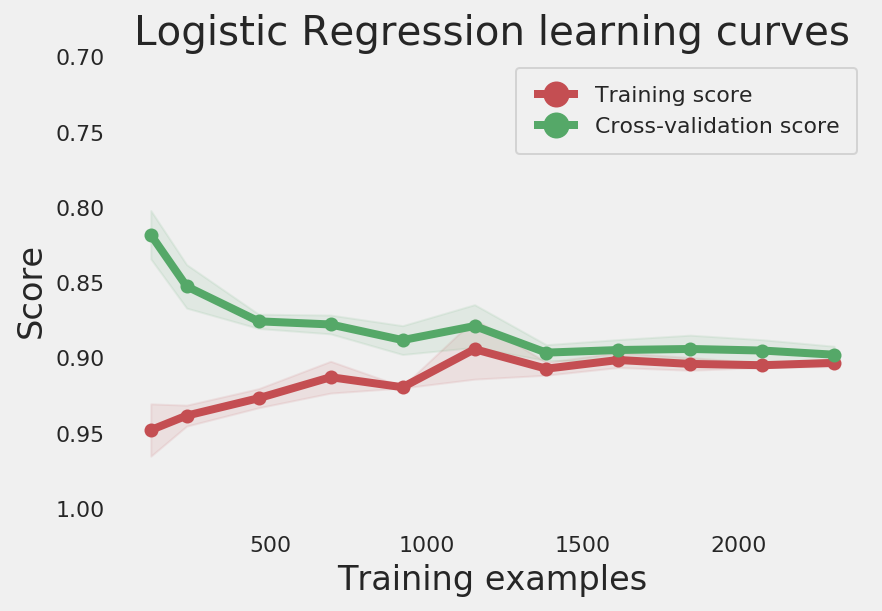

In [82]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### k-最近傍法

In [83]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 78.12 % 


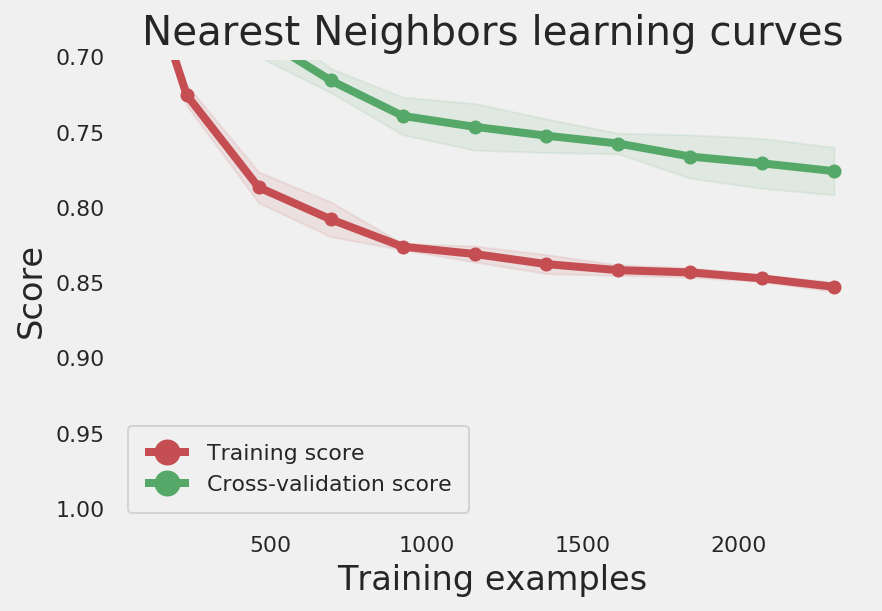

In [84]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 決定木

In [85]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 84.07 % 


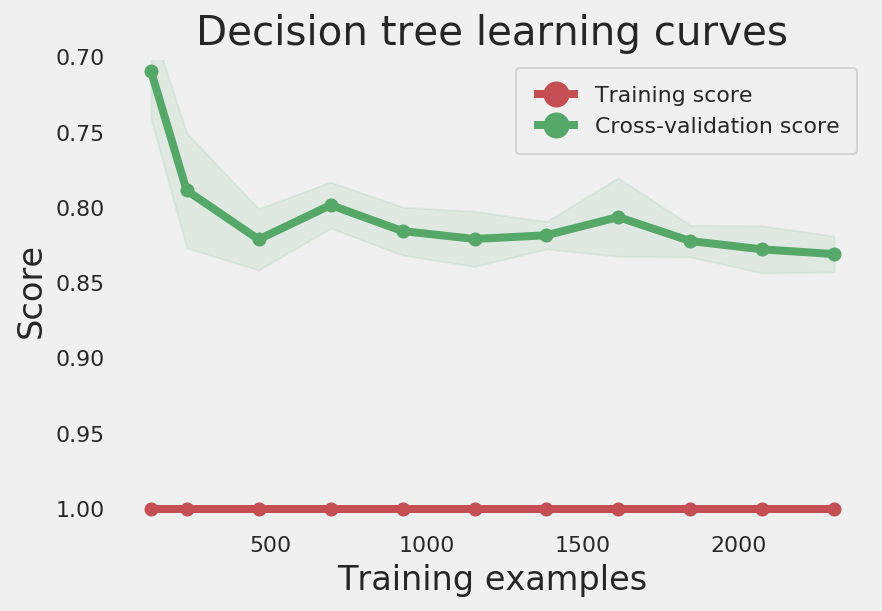

In [86]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### ランダムフォレスト

In [89]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 89.47 % 


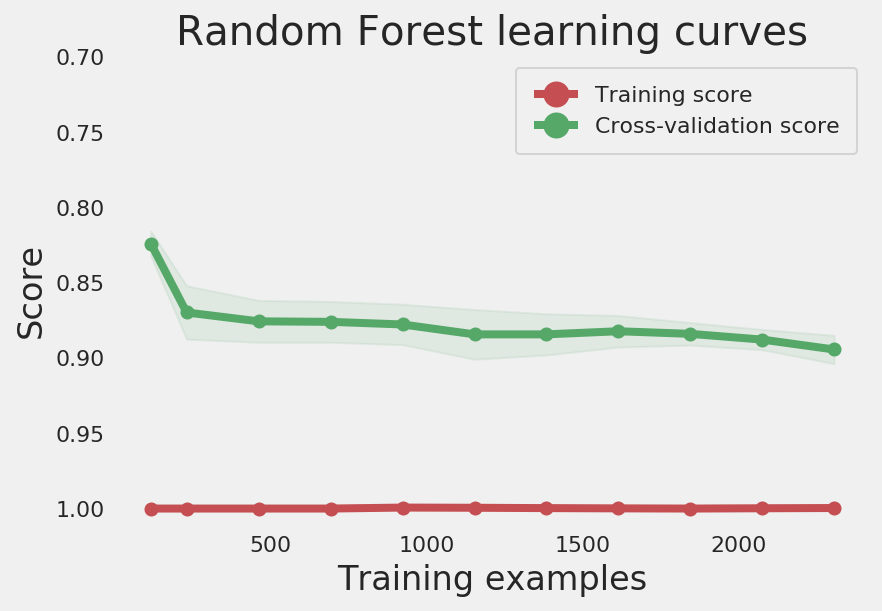

In [90]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### AdaBoost

AdaBoostは前の分類器の誤りに対して調整された次の分類器を作る。これが、適応的(Adaptive)という名称の由来である。AdaBoostはノイズの多いデータや異常値に影響を受けやすいが、多くの学習アルゴリズムより過剰適合の影響を受けにくい面が見られる。

AdaBoost は、それぞれの標本に対し、弱い分類器（weak classifier）を順に適用し、それぞれの分類器が正解したか否かを判断する。間違って分類された標本に対応する重みは、より重くされる（正しく分類された標本の場合は、重みを減らす）。これらの標本に対する重みから、次のループでは正しい分類器を早く探す事が出来る。

In [91]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 54.71 % 


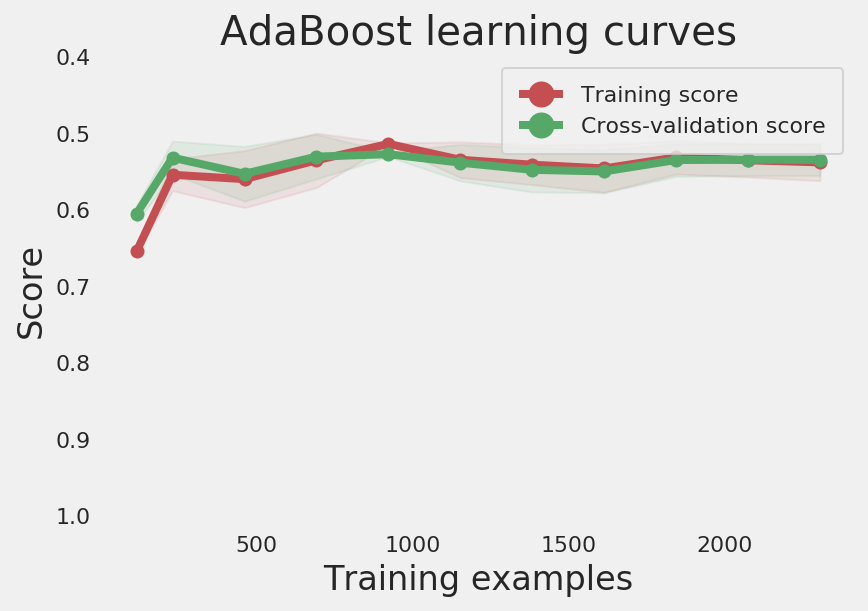

In [92]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 勾配ブースティング（Gradient Boosting Classifier）

勾配ブースティングとは、いわば弱い学習機を繰り返し強化するという仕組みである。いいかえれば、一つ前のモデルの残差を修正するような新しいモデルを追加していく。（このような内部の挙動ははパッケージを使っている場合に意識する必要はない）

**この処理には、相当の時間を要します。**

In [93]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 88.23 % 


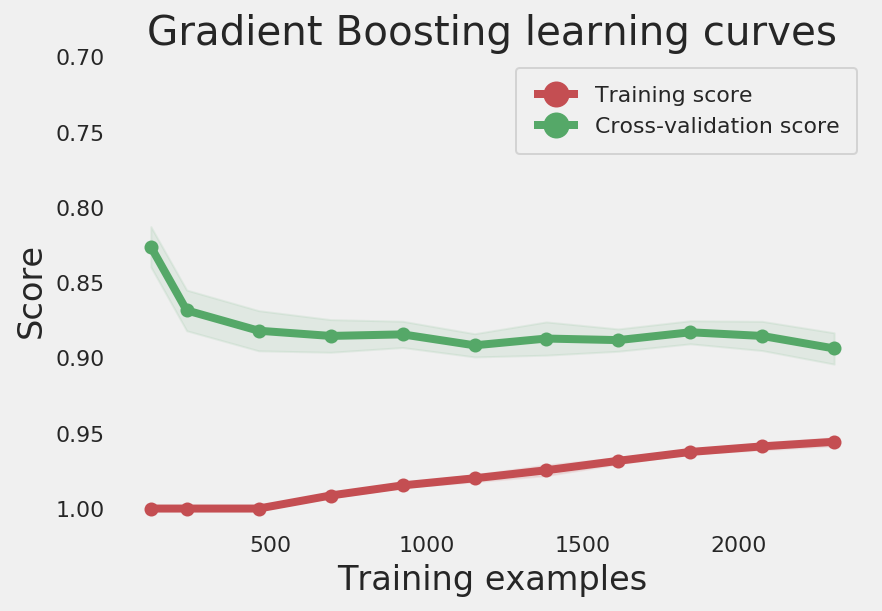

In [94]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### VotingClassifier

最後に、前のセクションで示したさまざまな分類器の結果を組み合わせて、分類モデルを改善する。これは、複数の分類器の予測の結果の中で、最も多かった（※）、顧客カテゴリを選択することで実現できる。sklearnパッケージのVotingClassifierを使用する。

※予測の平均を用いることもあり、「soft vote」と呼ばれる。

最初のステップとして、以前に見つけた最良のパラメーターを使用して、さまざまな分類器のパラメーターを調整する。

In [95]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

次に、さまざまな分類器の結果をマージする分類器`VotingClassifier`を定義する。

In [96]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')    

`VotingClassifier`を訓練する。

In [97]:
votingC = votingC.fit(X_train, Y_train)

適合率(Precision)を計算する。

In [98]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 88.50 % 


`VotingClassifier`分類器を定義する際に、上記で定義した分類器のセット全体のサブセット：Random Forest、k-Nearest Neighbors、およびGradient Boosting分類器のみを保持していることに注意。（実は、この選択は、次のセクションで実行される分類性能を元に行われている。）

## 予測性能検証

前のセクションでは、顧客を分類するためにいくつかの分類器がトレーニングされた。ここまで、分析全体は最初の10か月のデータに基づいていた。

このセクションでは、データフレーム`set_test`に保存されている最後の2か月間のデータセットでモデルをテストする。

In [99]:
basket_price = set_test.copy(deep = True)

最初のステップでは、トレーニングセットで使用したのと同じ手順に従ってこれらのデータを再フォーマットする。ただし、2つのデータセット間の時間差を考慮してデータを修正し、変数のカウントと合計に重みを付けて、トレーニングセットと同等になるようにする。

In [100]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count      min      max     mean       sum    categ_0  \
0      12347     10   224.82  1294.32   759.57   7595.70  20.017905   
1      12349      5  1757.55  1757.55  1757.55   8787.75  26.506216   
2      12352      5   311.73   311.73   311.73   1558.65  34.420813   
3      12356      5    58.35    58.35    58.35    291.75   0.000000   
4      12357      5  6207.67  6207.67  6207.67  31038.35  18.475531   

      categ_1    categ_2    categ_3    categ_4  
0   10.670511  24.271627  12.696657  32.343299  
1   46.021450  10.713778   4.513101  12.245455  
2   42.953838   7.217785   6.672441   8.735123  
3  100.000000   0.000000   0.000000   0.000000  
4   33.399810  28.350089   5.089832  14.684737

次に、テスト用データフレームをマトリックスに変換し、顧客が属するカテゴリを定義する変数のみを保持する。これは、トレーニングセットで使用されていた正規化の方法と同様である。

In [101]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].as_matrix()
scaled_test_matrix = scaler.transform(matrix_test)

ここでは、顧客が属するカテゴリを定義した検証用データを準備する。そのために、2か月間のデータ（count、min、max、およびsum）を使用する（分類器は、顧客の最初の購入データから得られるカラムのセットのみを使用する）。

ここでは、2か月間にわたって利用可能なデータを使用し、このデータを使用して顧客が属するカテゴリを決定する。次に、予測をこれらのカテゴリと比較することにより、分類器をテストできる。
クライアントが属するカテゴリを定義するためにkmeansのpredictメソッドは、11のクライアントクラスの重心から顧客までの距離を計算し、最小の距離をとるものを顧客のカテゴリーとして定めていた。

In [102]:
Y = kmeans.predict(scaled_test_matrix)

`transactions_per_user`から利用するカラムを選択する。

In [103]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

トレーニングされたさまざまな分類器の予測性能を調べる。

In [104]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 68.76 % 
______________________________ 
Logostic Regression
Precision: 74.60 % 
______________________________ 
k-Nearest Neighbors
Precision: 66.56 % 
______________________________ 
Decision Tree
Precision: 70.83 % 
______________________________ 
Random Forest
Precision: 73.81 % 
______________________________ 
Gradient Boosting
Precision: 73.97 % 


最後に、それぞれの予測を組み合わせることにより、分類器の品質を向上させることができる。ランダムフォレスト、勾配ブースティング、k-Nearest Neighborsの予測を組み合わせることを選択した。これにより、予測がわずかに改善される。

In [105]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 74.36 % 


## 結論
このノートブックに記載されている作業は、1年間のEコマースプラットフォームでの購入に関する詳細を提供するデータベースに基づいている。データセットの各エントリは、特定の顧客による特定の日付での製品の購入を表す。合計で、およそ4000の顧客がデータに含まれている。

最初のE-コマースサイトへの訪問から、顧客が行う購入のタイプと、1年間の訪問の数を予測できる分類器を開発することにした。。

最初に、サイトで販売されているさまざまな製品を記述することであり、最初の分類の対象でした。そこで、さまざまな製品を5つの主要な商品カテゴリに分類した。

2番目のステップでは、10か月間の消費習慣を分析して、顧客の分類を行った。クライアントが通常購入する製品の種類、訪問数、10か月間に費やした金額に基づいて、クライアントを11の主要なカテゴリに分類した。

これらのカテゴリが確立したら、最終的にこれらの11のカテゴリのいずれかに消費者を分類できるようにすることを目的とした複数の分類子をトレーニングした。このため、分類子は次の5つの変数に基づいています。

- mean：現在の購入の合計金額
- categ_N（ N∈ [ 0 ：4 ]） ：製品カテゴリに対して費やされた割合 

最後に、データセットの最後の2か月間で、さまざまな分類器の予測性能を検証した。データは、2つのステップで処理される。

最初に、すべてのデータ（2か月間）が考慮されて各クライアントが属するカテゴリが定義され、次に予測がこのカテゴリ割り当てと比較されました。その後、75％の顧客に適切なクラスが与えられていることがわかった。

分類器のパフォーマンスは概ね正しいように見えるが、モデルの潜在的な欠点を考慮することも重要。

特に、考慮されていないバイアスとしては、購入の季節性と、購入習慣が時期（たとえば、クリスマス）に依存する可能性がある。
この季節的な影響により、10か月間に定義されたカテゴリは、過去2か月から推定されたカテゴリとはまったく異なる場合がありえる。このようなバイアスを修正するためには、より長い期間をカバーするデータを持つことが有益となる。